# Plot TNG Cluster analysis
## Written by Eric Rohr

In [1]:
### import modules
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
import scipy.stats
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
%matplotlib ipympl 

plt.style.use('fullpage.mplstyle')

zs, times = ru.return_zs_costimes()
times /= 1.0e9 # [Gyr]
scales = 1. / (1.+ zs)

In [2]:
! pwd

/vera/u/reric/Scripts


In [3]:
### set global variables and plotting kwargs
mass_binwidth = 0.1
time_binwidth = 0.5

NGaussSmooth = 1000

figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

figsizewidth_fullpage = figsizewidth
figsizeheight_fullpage = figsizewidth_fullpage * figsizeratio
figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

gal_boundary = 0.15

hist_kwargs         = dict(histtype='step')
sc_kwargs           = dict(s=4**2, alpha=1.0, zorder=1.01, marker=r"$\rm{{{0:s}}}$".format('\u25EF'), linewidths=0.75)
plot_kwargs         = dict(fillstyle='none', ms=1, mew=0.75, alpha=0.1)
vline_kwargs        = dict(marker='None', ls='-', zorder=1, alpha=0.5, lw=1.0)
median_kwargs       = vline_kwargs.copy()
median_kwargs['lw'] = 2.0
text_kwargs         = dict()
axislabel_kwargs    = dict()
legend_kwargs       = dict()
one_one_kwargs      = dict(ls='-', marker='None', c='k', zorder=1.0, lw=2.5)
gal_boundary_kwargs = dict(marker='None', ls='--', c='k', zorder=0.9)

Mstarz0_key = 'Subhalo_Mstar_Rgal_z0'
M200cz0_key = 'HostGroup_M_Crit200_z0'
muz0_key    = 'muz0'
MCGasz0_key = 'SubhaloColdGasMass_z0'
MHGasz0_key = 'SubhaloHotGasMass_z0'
MTGasz0_key = 'SubhaloGasMass_z0'

Mstarz0_label   = r'$M_{\star}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
M200cz0_label   = r'$M_{\rm 200c}^{\rm host}(z=0)\, [{\rm M_\odot}]$'
muz0_label      = r'$\mu \equiv M_{\star}^{\rm sat} / M_{\rm 200c}^{\rm host} (z=0)$'
muz0_label_words = r'Mass Ratio $[\mu(z=0)]$'
MCGasz0_label   = r'$M_{\rm ColdGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MHGasz0_label   = r'$M_{\rm HotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MTGasz0_label   = r'$M_{\rm TotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
Nbranches_label = r'\# Satellites' 

tau0_infall_HG_key = 'CosmicTime_tau_infall_HotGas0'
tau100_infall_HG_key = 'CosmicTime_tau_infall_HotGas100'
tau0_infall_G_key = 'CosmicTime_tau_infall_Gas0'
tau100_infall_G_key = 'CosmicTime_tau_infall_Gas100'
tau0_infall_CG_key = 'CosmicTime_tau_infall_ColdGas0'
tau100_infall_CG_key = 'CosmicTime_tau_infall_ColdGas100'

tstrip_infall_HG_key = 'Tstrip_tau_infall_HotGas_tau0-tau100'
tstrip_infall_CG_key = 'Tstrip_tau_infall_ColdGas_tau0-tau100'
tstrip_infall_AG_key = 'Tstrip_tau_infall_Gas_tau0-tau100'

tau0_infall_label = r'Cosmic Time at Infall [$\tau_0$] [Gyr]'
tau100_infall_HG_label = r'Cosmic Time at $\tau_{100}^{\rm HotGas}$ [Gyr]'
tau100_infall_CG_label = r'Cosmic Time at $\tau_{100}^{\rm ColdGas}$ [Gyr]'
tau100_infall_AG_label = r'Cosmic Time at $\tau_{100}^{\rm Gas}$ [Gyr]'

tstrip_infall_HG_label = r'Hot Gas Loss [$\tau_{100}^{\rm HotGas} - \tau_{0}$] [Gyr]'
tstrip_infall_CG_label = r'Hot Gas Loss [$\tau_{100}^{\rm ColdGas} - \tau_{0}$] [Gyr]'
tstrip_infall_AG_label = r'Hot Gas Loss [$\tau_{100}^{\rm Gas} - \tau_{0}$] [Gyr]'

tau0_key = tau0_infall_HG_key
infall_key = tau0_key
tau0_label = tau0_infall_label
infall_label = tau0_label
tau100_key = tau100_infall_HG_key
tau100_label = tau100_infall_HG_label
tstrip_key = tstrip_infall_HG_key
tstrip_label = tstrip_infall_HG_label
tstrip_label_long = r'Total Hot Gas Loss Duration [$\tau_{100}^{\rm HotGas} - \tau_{0}$] [Gyr]'

d0_RPS_tot_key = 'HostCentricDistance_norm_tau_infall_HotGas0'
d0_RPS_tot_label = r'Distance to $z=0$ Host at infall $[R_{\rm 200c}^{\rm host}({\rm infall})]$'

fgas_infall_key = 'SubhaloColdGasFraction_tau_RPS_tot0'
fgas_infall_label = r'$f_{\rm ColdGas}(\tau_0)\equiv M_{\rm ColdGas}^{\rm sat}(\tau_0) / M_{\star}^{\rm sat}(\tau_0)$'
SHGM_infall_key = 'SubhaloHotGasMass_tau_infall_HotGas0'
SHGM_infall_label = r'$M_{\rm HotGas}^{\rm sat}(\tau_0)$'

Napopass_tau100_key = 'Napopass_tau_infall_HotGas100'
Napopass_tau100_label = r'Number of Orbits'

HCDnz0_key = 'HostCentricDistance_norm_z0'


direc_list = ['../Figures/TNGCluster/']
direc_PP ='../Figures/TNGCluster/'
direc_list = [direc_PP]


In [4]:
# define plotting labels and kwargs for each taudcit_key, gasz0_key combination

all_key = 'all'
clean_key = 'clean'
PP_key = 'preprocessed'
BP_key = 'backsplash_prev'
taudict_keys = [all_key, clean_key, PP_key, BP_key]

all_label = 'All'
clean_label = 'First-Infalling'
PP_label = 'Pre-Processed'
BP_label = 'Backsplash'
taudict_labels = [all_label, clean_label, PP_label, BP_label]
taudict_labels_dict = {all_key:all_label, clean_key:clean_label, PP_key:PP_label, BP_key:BP_label}

tot_key = 'tot'
gas_key = 'gasz0'
nogas_key = 'nogasz0'
gasz0_keys = [tot_key, gas_key, nogas_key]

tot_label = 'All'
gas_label = r'$M_{\rm Gas}^{\rm sat}(z=0) > 10^{7}\, {\rm M_\odot}$'
nogas_label = r'$M_{\rm Gas}^{\rm sat}(z=0) < 10^{7}\, {\rm M_\odot}$'
gasz0_labels = [tot_label, gas_label, nogas_label]
gasz0_labels_dict = {tot_key:tot_label, gas_key:gas_label, nogas_key:nogas_label}

### define some general plotting parameters for each taudict_key, gasz0_key combination
### general colorscheme:
### jellyfish: green (for green valley galaxies, and images are typically green, blue and yellow)
### nonjellyf: purple (could be starforming and blue or quiescent and red)
### inspected: black 
### gasz0: blue, because they still have gas and are likely star forming
### nogasz0: red, because they have no gas and are quenched
### tot: the same color as standard

histkwargs_clean = dict(**hist_kwargs, color='tab:green', lw=2.5, zorder=2.2)
histkwargs_pp = dict(**hist_kwargs, color='tab:purple', lw=2.0, zorder=2.1)
histkwargs_all = dict(**hist_kwargs, color='silver', lw=3.5, zorder=1.9)
histkwargs_BP = dict(**hist_kwargs, color='tab:orange')
#histkwargs_all['histtype'] = 'bar'
histkwargs_dict_temp = {clean_key:histkwargs_clean, PP_key:histkwargs_pp, all_key:histkwargs_all, BP_key:histkwargs_BP}

histkwargs_dict = {}
for taudict_key in taudict_keys:
    histkwargs_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        histkwargs_dict[taudict_key][gasz0_key] = histkwargs_dict_temp[taudict_key].copy()
    #histkwargs_dict[taudict_key][gas_key]['color'] = 'tab:blue'
    #histkwargs_dict[taudict_key][nogas_key]['color'] = 'tab:red'
    

cmaps_dict_temp = {clean_key:mpl.cm.get_cmap('Greens'),
                   PP_key:mpl.cm.get_cmap('Purples'),
                   all_key:mpl.cm.get_cmap('Greys'),
                   BP_key:mpl.cm.get_cmap('Oranges')}

cmaps_dict = {}
for taudict_key in taudict_keys:
    cmaps_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        cmaps_dict[taudict_key][gasz0_key] = cmaps_dict_temp[taudict_key].copy()
    #cmaps_dict[taudict_key][gas_key] = mpl.cm.get_cmap('Blues')
    #cmaps_dict[taudict_key][nogas_key] = mpl.cm.get_cmap('Reds')
    
    
## define histogram kwargs for binning tstrip by M200cz0, Mstarz0, or tau0_infall ###
### NB -- must have two sets of histogram kwargs for the two definitions of tstrip ###
sim = 'L680n8192TNG'
M200cz0_bins = [14.0, 14.5, 15.0, 15.5] 
Mstarz0_bins = [10.0, 10.5, 11.0, 12.0]
SCGM_infall_bins = [9.0, 9.5, 10., 10.5]
tau0_bins = [5.0, 7.5, 10.0, 12.5]
Norbit_bins = [0, 1, 2, 4]

tstrip_histkwargs_dict = {}
histkwargs_list_key = 'histkwargs_list'

# M200cz0
tstrip_histkwargs_dict[M200cz0_key] = dict(key=M200cz0_key, label=M200cz0_label,
                                           savelabel=r'm200cz0', bins=M200cz0_bins)

histkwargs_list    = [{}] * (len(M200cz0_bins) - 1)
histkwargs_list[0] = dict(**hist_kwargs, color='orangered', lw=1.5, zorder=1.05)
histkwargs_list[1] = dict(**hist_kwargs, color='red', lw=2.5, zorder=1.15)
histkwargs_list[2] = dict(**hist_kwargs, color='darkred', lw=3.5, zorder=1.25)
tstrip_histkwargs_dict[M200cz0_key][histkwargs_list_key] = histkwargs_list
    
# SCGM(infall)
histkwargs_list    = [{}] * (len(SCGM_infall_bins) - 1)
tstrip_histkwargs_dict[SHGM_infall_key] = dict(key=SHGM_infall_key, label=SHGM_infall_label,
                                               savelabel=r'SHGMinfall', bins=SCGM_infall_bins)
histkwargs_list[0] = dict(**hist_kwargs, color='darkorange', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='orange', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='wheat', lw=1.0)
tstrip_histkwargs_dict[SHGM_infall_key][histkwargs_list_key] = histkwargs_list

# Mstarz0
histkwargs_list = [{}] * (len(Mstarz0_bins) - 1)

tstrip_histkwargs_dict[Mstarz0_key] = dict(key=Mstarz0_key, label=Mstarz0_label,
                                           savelabel=r'mstarz0', bins=Mstarz0_bins)

histkwargs_list[0] = dict(**hist_kwargs, color='darkmagenta', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='mediumpurple', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='violet', lw=1.0)
tstrip_histkwargs_dict[Mstarz0_key][histkwargs_list_key] = histkwargs_list
      
# tau0_infall 
histkwargs_list  = [{}] * (len(tau0_bins) - 1)

tstrip_histkwargs_dict[tau0_key] = dict(key=tau0_key, label=tau0_label,
                                        savelabel='infalltime', bins=tau0_bins)

histkwargs_list[0] = dict(**hist_kwargs, color='darkgreen', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='limegreen', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='palegreen', lw=1.0)
tstrip_histkwargs_dict[tau0_key][histkwargs_list_key] = histkwargs_list

# Nubmer of completed orbits (== Number of apocenter passes)
tstrip_histkwargs_dict[Napopass_tau100_key] = {histkwargs_list_key:histkwargs_list.copy()}
tstrip_histkwargs_dict[Napopass_tau100_key]['bins'] = Norbit_bins
tstrip_histkwargs_dict[Napopass_tau100_key]['savelabel'] = 'Norbit'
tstrip_histkwargs_dict[Napopass_tau100_key]['label'] = Napopass_tau100_label
       
# add these dictionaries to the class
tstrip_histbins_dict = {tstrip_key:tstrip_histkwargs_dict}


In [5]:
class TNGSim:
    
    def __init__(self, sim, taudict_key, gasz0_key,
                 tstrip_histbins_dict=tstrip_histbins_dict):
        """
        Initialize the TNGsim class.
        sim == 'TNG50-1' 
        taudict_key == jel_key, non_key, or ins_key
        gasz0_key == tot_key, gas_key, nogas_key
        M200cz0_bins, Mstarz0_bins should each be length 4, including all bin edges
        """ 
        self.sim  = sim
        self.M200cz0_bins= M200cz0_bins
        self.Mstarz0_bins = Mstarz0_bins
        self.taudict_key = taudict_key
        self.gasz0_key = gasz0_key
        self.taudict_fname = return_taudict_fname(self)
        
        self.sim_label = 'TNG-Cluster'
        self.taudict_label = taudict_labels_dict[taudict_key]
        self.gasz0_label = gasz0_labels_dict[gasz0_key]
        
        #self.taudict_label = taudict_labels_dict[taudict_key]
        
        #self.gasz0_label = gasz0_labels_dict[gasz0_key]
                       
        # load the tau dictionary 
        self.tau_dict = load_taudict(self, self.taudict_fname)
        
        self.histkwargs = histkwargs_dict[taudict_key][gasz0_key]
        self.cmap = cmaps_dict[taudict_key][gasz0_key]
        self.plotkwargs = dict(**plot_kwargs, color=self.histkwargs['color'])
        
        sckwargs_dict = {}
        sckwargs_dict[M200cz0_key] = dict(**sc_kwargs, cmap='plasma',
                                          norm=mpl.colors.LogNorm(vmin=10.**min(M200cz0_bins), vmax=10.**(max(M200cz0_bins))))
        sckwargs_dict[Mstarz0_key] = dict(**sc_kwargs, cmap='viridis',
                                          norm=mpl.colors.LogNorm(vmin=10.**(min(Mstarz0_bins)), vmax=10.**(max(Mstarz0_bins))))
        sckwargs_dict[muz0_key]    = dict(**sc_kwargs, cmap='cubehelix_r',
                                          norm=mpl.colors.LogNorm(vmin=10.**(-5.5), vmax=10.**(-2.5)))
        self.sckwargs_dict = sckwargs_dict
        
        self.tstrip_histbins_dict = tstrip_histbins_dict
        
        self.save_label = sim + '_' + taudict_key + '_' + gasz0_key
        self.plot_label = '%s %s \n %s (%d)'%(self.sim_label, self.taudict_label, self.gasz0_label, self.tau_dict['SubfindID'].size)
        
        self.M200cz0_bins= M200cz0_bins
        
        return

def load_taudict(Sim, fname):

    result = {}
    with h5py.File('../Output/%s_subfindGRP/'%Sim.sim + fname, 'a') as f:
        group = f['Group']
        for dset_key in group.keys():
            result[dset_key] = group[dset_key][:]
        f.close()
        
    return result
        
    
def return_taudict_fname(Sim):
    """ 
    return the taudict filename for the given sim, assuming only satellites 
    """
    return 'subfind_%s_tau_%s_%s.hdf5'%(Sim.sim, Sim.taudict_key, Sim.gasz0_key)

    
def add_redshift_sincez2(ax, label=True):
    """
    For a given x axis, add redshift since z=2 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91, 99]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1', '0']

    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.5))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)
    xhilim = 14.1

    ax.set_xlim(xlolim, xhilim)

    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    
    yscale = ax.get_yscale()
    if yscale == 'log':
        locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
        ax.yaxis.set_minor_locator(locmin)
        #ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    if label:
        redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_xticklabels(ticks_labels)
    else:
        redshift_ax.set_xticklabels([])
        
    return ax



In [6]:
sim = 'L680n8192TNG'
TNGCluster_all = TNGSim(sim, all_key, tot_key)
TNGCluster_all_gasz0 = TNGSim(sim, all_key, gas_key)
TNGCluster_all_nogasz0 = TNGSim(sim, all_key, nogas_key)
TNGCluster_all_tot = TNGCluster_all

TNGCluster_clean = TNGSim(sim, clean_key, tot_key)
TNGCluster_clean_gasz0 = TNGSim(sim, clean_key, gas_key)
TNGCluster_clean_nogasz0 = TNGSim(sim, clean_key, nogas_key)
TNGCluster_clean_tot = TNGCluster_clean

TNGCluster_PP = TNGSim(sim, PP_key, tot_key)
TNGCluster_PP_gasz0 = TNGSim(sim, PP_key, gas_key)
TNGCluster_PP_nogasz0 = TNGSim(sim, PP_key, nogas_key)
TNGCluster_PP_tot = TNGCluster_PP

TNGCluster_BP = TNGSim(sim, BP_key, tot_key)
TNGCluster_BP_gasz0 = TNGSim(sim, BP_key, gas_key)
TNGCluster_BP_nogasz0 = TNGSim(sim, BP_key, nogas_key)
TNGCluster_BP_tot = TNGCluster_BP

all_Sims = [TNGCluster_all, TNGCluster_clean, TNGCluster_PP,
           TNGCluster_all_gasz0, TNGCluster_all_nogasz0, 
           TNGCluster_clean_gasz0, TNGCluster_clean_nogasz0,
           TNGCluster_PP_gasz0, TNGCluster_PP_nogasz0]

In [7]:
fgas_z0_key = 'fgas_z0'
fCgas_z0_key = 'fCgas_z0'
fHgas_z0_key = 'fHGas_z0'

SubhaloMassz0_key = 'SubhaloMass_z0'

fgas_z0_keys = [fgas_z0_key,
                fCgas_z0_key,
                fHgas_z0_key]

SubhaloGasMassz0_keys = [MTGasz0_key,
                        MCGasz0_key,
                        MHGasz0_key]

time_since_infall_key = 'TimeSinceInfall'

def add_fgas_dset(Sim):
    """
    Add dataset to tau_dict.
    """
    tau_dict = Sim.tau_dict
    SubhaloMassz0 = tau_dict[SubhaloMassz0_key]
    
    result = np.zeros(SubhaloMassz0.size, SubhaloMassz0.dtype)
    
    for i, fgas_z0_key in enumerate(fgas_z0_keys):
        dset = result.copy()
        gas_mass_key = SubhaloGasMassz0_keys[i]
        gas_mass = tau_dict[gas_mass_key]
        mask = gas_mass > 0
        dset[mask] = gas_mass[mask] / SubhaloMassz0[mask]
        tau_dict[fgas_z0_key] = dset
        
    return
        
def add_time_since_infall_dset(Sim):
    """
    Add dataset to tau_dict.
    """
    tau_dict = Sim.tau_dict
    tau0 = tau_dict[tau0_infall_HG_key]
    result = np.zeros(tau0.size, tau0.dtype)
    indices = tau0 > 0
    time_z0 = tau_dict['CosmicTime_z0'][indices][0]
    result[indices] = time_z0 - tau0[indices]
    tau_dict[time_since_infall_key] = result
    
    return
    
Sims = [TNGCluster_all, TNGCluster_clean, TNGCluster_PP]
for Sim in all_Sims:
    add_fgas_dset(Sim)
    add_time_since_infall_dset(Sim)




In [8]:
tau_dict = TNGCluster_all.tau_dict
Mstarz0 = tau_dict[Mstarz0_key]
Mstarz0.size, Mstarz0[Mstarz0 > 10.**(10.5)].size, Mstarz0[Mstarz0 > 10.**(11.0)].size, Mstarz0[Mstarz0 > 10.**(11.5)].size

(32977, 13449, 2959, 212)

In [9]:
print(TNGCluster_all.tau_dict['SubfindID'].size, TNGCluster_clean.tau_dict['SubfindID'].size, TNGCluster_PP.tau_dict['SubfindID'].size)
print(TNGCluster_all_gasz0.tau_dict['SubfindID'].size, TNGCluster_all_nogasz0.tau_dict['SubfindID'].size, TNGCluster_clean_gasz0.tau_dict['SubfindID'].size, TNGCluster_clean_nogasz0.tau_dict['SubfindID'].size)
print(TNGCluster_PP_gasz0.tau_dict['SubfindID'].size, TNGCluster_PP_nogasz0.tau_dict['SubfindID'].size)

32977 12146 12940
4697 28280 2252 9894
1264 11676


In [10]:
### 1D histogram plots binned by taudict_keys (jellyfish, nonjellyf, inspected) ###
def plot_tracers_mass_distributions_z0(Sims, savefig=False):
    """
    Plot the 1D histograms for 6 panels defined below. Could be generalized...
    Sims should be a list of TNGSim classes, starting with the broadest possible sample (i.e., inspected, tot)
    """

    x_keys   = [Mstarz0_key, M200cz0_key, muz0_key, MCGasz0_key, MHGasz0_key, MTGasz0_key]
    x_labels = [Mstarz0_label, M200cz0_label, muz0_label, MCGasz0_label, MHGasz0_label, MTGasz0_label]
    
    fig, axs = plt.subplots(2, 3, sharey='row')
    axs[0,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    axs[1,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    axs, legend_handels = plot_1Dhistograms(Sims, axs, x_keys, x_labels, y_step=0.15)
    for ax in axs.flatten():
        ax = plot_all_logticks(ax, plot_minor_ticks=True)
    
    fig.legend(handles=legend_handels, ncol=len(Sims), bbox_to_anchor=(0.5, 1.05), loc='lower center', bbox_transform=axs[0,1].transAxes,
               title=Sims[0].sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_massdistributions_z0.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, axs

def plot_1Dhistograms(Sims, axs, x_keys, x_labels,
                      x_text=0.05, y_text=0.95, y_step=0.1, ha='left', va='top',
                      plot_mask=True):
    """
    fill the panels for 1D histograms and return fig, ax, and legend_handels
    Also adds the number of points with x <= 0. 
    """
    if isinstance(x_keys, six.string_types):
        x_keys = [x_keys]
    if isinstance(x_labels, six.string_types):
        x_labels = [x_labels]
    
    if len(axs.flat) != len(x_keys) or len(axs.flat) != len(x_labels):
        print('Incorrect number of axs, x_keys, or x_labels. Retunrning')
        return
    
    for ax_i, ax in enumerate(axs.flat):
        x_key   = x_keys[ax_i]
        x_label = x_labels[ax_i]
        ax.set_xlabel(x_label, **axislabel_kwargs)
        ax.set_yscale('log')

        ax = plot_1Dhist_panel(Sims, ax, x_key, plot_mask=plot_mask) 
                
    # generate legend handels 
    legend_handels = add_histlegend(Sims)
    
    return axs, legend_handels
 
def plot_1Dhist_panel(Sims, ax, x_key,
                      plot_mask=True):
    """
    Calculate the 1D histogram and add to an existing axis.
    Loop over the taudict_keys and add each to the same axis.
    For the x values <= 0, there's the option either to plot them 
    at 1.0e-2 * min(x), or to omit them entirely. 
    Returns the ax and the number of points where x <= 0
    """
    
    ### use the first Sim to set the bins ###
    x = Sims[0].tau_dict[x_key].copy()
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if (tau100_key in x_key):
        x_loval = 0
        mask = x <= x_loval
        min_plot = x.max()
        x[mask] = min_plot
        binwidth = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif (tstrip_key in x_key):
        x_loval = 0.1
        mask = x <= x_loval
        min_plot = -10.
        x[mask] = min_plot
        binwidth = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif ('T' in x_key) or ('tau' in x_key):
        x_loval = 0.1
        mask = x <= x_loval
        min_plot = 0.
        x[mask] = min_plot
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif ('M' in x_key):
        x_loval = 9.0e6
        mask = x <= x_loval
        min_plot = 1.0e6
        x[mask] = min_plot
        binwidth = mass_binwidth
        bins, bincents = ru.returnlogbins(x, binwidth) 
        ax.set_xscale('log')
    elif ('mu' in x_key):
        x_loval = 1.0e-7
        mask = x <= x_loval
        min_plot = x_loval
        x[mask] = min_plot
        binwidth = mass_binwidth
        bins, bincents = ru.returnlogbins(x, binwidth) 
        ax.set_xscale('log')
        
    for Sim in Sims:
        # load dataset and validate
        x = Sim.tau_dict[x_key].copy()
        mask = x <= x_loval
        print(Sim.save_label, mask.size, mask[mask].size)

        if plot_mask:
            x[mask] = min_plot
        else:
            x = x[~mask]
            
        label = Sim.gasz0_key + ' (%d)'%len(x)
        histkwargs = Sim.histkwargs

        ax.hist(x, bins, label=label, **histkwargs)
    # finish loop over Sims
        
    return ax


def add_histlegend(Sims):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for Sim in Sims:
        histkwargs = Sim.histkwargs
        label = Sim.taudict_label + ' (%d)'%(Sim.tau_dict[M200cz0_key].size)
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result


def plot_all_logticks(ax, x_axis=True, plot_minor_ticks=False):
    """
    helper function that ensures that each base 10 power is shown.
    assumes to be run on x-axis, but functions similarly for y-axis.
    """
    if x_axis:
        x_lims = ax.get_xlim()
        x_lolog = ru.ceil_to_value(np.log10(x_lims[0]), 1.0)
        x_hilog = ru.floor_to_value(np.log10(x_lims[1]), 1.0)
        Ndex = x_hilog - x_lolog + 1
        
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numdecs=Ndex, numticks=Ndex))
        if plot_minor_ticks:
            locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
            ax.xaxis.set_minor_locator(locmin)
            
    else:
        ylims = ax.get_ylim()
        y_lolog = ru.ceil_to_value(np.log10(y_lims[0]), 1.0)
        y_hilog = ru.floor_to_value(np.log10(y_lims[1]), 1.0)
        Ndex = yhilog - y_lolog + 1

        ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numdecs=Ndex, numticks=Ndex))
        if plot_minor_ticks:
            locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
            ax.yaxis.set_minor_locator(locmin)
            
    return ax

    

In [11]:
savefig=False

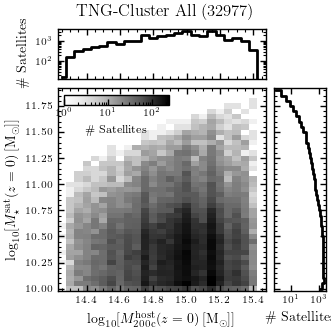

In [12]:
Sim = TNGCluster_all
tau_dict = Sim.tau_dict

x_key = M200cz0_key
y_key = Mstarz0_key

x_label = M200cz0_label
y_label = Mstarz0_label

x = np.log10(tau_dict[x_key])
y = np.log10(tau_dict[y_key])

indices = (x > 0) & (y > 0)

binwidth = 0.05

x_bins, x_bincents = ru.returnbins(x, binwidth)
y_bins, y_bincents = ru.returnbins(y, binwidth)    

# generate 2D histogram and smooth values
hist = np.histogram2d(x[indices], y[indices], bins=[x_bins, y_bins])
vals = hist[0].T
x_hist = np.sum(vals, axis=0)
y_hist = np.sum(vals, axis=1)

fig = plt.figure(figsize=(figsizewidth_column,figsizewidth_column))
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=(4, 1), height_ratios=(1, 4),
                       left=0.1, right=0.9, bottom=0.1, top=0.9,
                       wspace=0.05, hspace=0.05)

ax10 = fig.add_subplot(gs[1, 0])
ax10.set_ylabel(r'$\log_{10}[$'+ y_label + r'$]$')
ax10.set_xlabel(r'$\log_{10}[$'+ x_label + r'$]$')
h = ax10.hist2d(x, y, bins=(x_bins, y_bins), cmap='Greys', norm=mpl.colors.LogNorm())
cax10 = inset_axes(ax10, width='50%', height='5%', loc='upper left')
cbar = plt.colorbar(h[3], cax=cax10, orientation='horizontal')
cbar.set_label(Nbranches_label, labelpad=5, fontsize='small')
cbar.ax.tick_params(labelsize='x-small')

ax00 = fig.add_subplot(gs[0, 0], sharex=ax10)
ax00.set_ylabel(Nbranches_label)
ax00.set_yscale('log')
ax00.step(x_bincents, x_hist, where='mid', marker='None', ls='-')
ax00.tick_params(axis="x", labelbottom=False)

ax11 = fig.add_subplot(gs[1, 1], sharey=ax10)
ax11.set_xlabel(Nbranches_label)
ax11.set_xscale('log')
ax11.step(y_hist, y_bincents, where='mid', marker='None', ls='-')
ax11.tick_params(axis="y", labelleft=False)

fig.suptitle('TNG-Cluster All (%d)'%x.size) 
fname = '%s_massdistribtuions_z0.pdf'%Sim.save_label
savefig=False
if (savefig):
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')


In [13]:
for key in tau_dict.keys():
    if 'tau_medpeak_Mass0' in key:
        print(key)

CosmicTime_tau_medpeak_Mass0
HostCentricDistance_norm_tau_medpeak_Mass0
HostGroup_M_Crit200_tau_medpeak_Mass0
HostGroup_R_Crit200_tau_medpeak_Mass0
HostSubhalo_Mstar_Rgal_tau_medpeak_Mass0
Napopass_tau_medpeak_Mass0
Nperipass_tau_medpeak_Mass0
SnapNum_tau_medpeak_Mass0
SubhaloColdGasMass_tau_medpeak_Mass0
SubhaloGasMass_tau_medpeak_Mass0
SubhaloHotGasMass_tau_medpeak_Mass0
SubhaloMass_tau_medpeak_Mass0
Subhalo_Mstar_Rgal_tau_medpeak_Mass0
min_Dperi_norm_tau_medpeak_Mass0
min_Dperi_phys_tau_medpeak_Mass0
min_HostCentricDistance_norm_tau_medpeak_Mass0
min_HostCentricDistance_phys_tau_medpeak_Mass0


L680n8192TNG_all_tot 32977 0
L680n8192TNG_clean_tot 12146 0
L680n8192TNG_preprocessed_tot 12940 0
L680n8192TNG_all_tot 32977 0
L680n8192TNG_clean_tot 12146 0
L680n8192TNG_preprocessed_tot 12940 0
L680n8192TNG_all_tot 32977 0
L680n8192TNG_clean_tot 12146 0
L680n8192TNG_preprocessed_tot 12940 0
L680n8192TNG_all_tot 32977 28490
L680n8192TNG_clean_tot 12146 10012
L680n8192TNG_preprocessed_tot 12940 11731
L680n8192TNG_all_tot 32977 28124
L680n8192TNG_clean_tot 12146 9863
L680n8192TNG_preprocessed_tot 12940 11631
L680n8192TNG_all_tot 32977 28087
L680n8192TNG_clean_tot 12146 9850
L680n8192TNG_preprocessed_tot 12940 11615


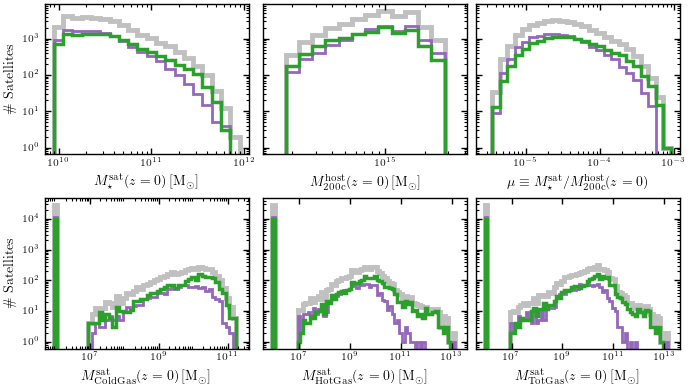

In [14]:
Sims = [TNGCluster_all, TNGCluster_clean, TNGCluster_PP]

fig, axs = plot_tracers_mass_distributions_z0(Sims, savefig=savefig)

In [15]:
tau_dict = TNGCluster_all.tau_dict
MHGasz0 = tau_dict[MHGasz0_key]
mask = MHGasz0 < 1.0e7
mask.size, mask[mask].size, mask[~mask].size

(32977, 28129, 4848)

In [16]:
tau_dict = TNGCluster_PP.tau_dict
MHGasz0 = tau_dict[MHGasz0_key]
mask = MHGasz0 < 1.0e7
mask.size, mask[mask].size, mask[~mask].size

(12940, 11634, 1306)

In [17]:
tau_dict = TNGCluster_PP_gasz0.tau_dict
MHGasz0 = tau_dict[MHGasz0_key]
mask = MHGasz0 < 1.0e7
mask.size, mask[mask].size, mask[~mask].size

(1264, 20, 1244)

In [18]:
tau_dict = TNGCluster_PP_nogasz0.tau_dict
MHGasz0 = tau_dict[MHGasz0_key]
mask = MHGasz0 < 1.0e7
mask.size, mask[mask].size, mask[~mask].size

(11676, 11614, 62)

In [19]:
def plot_2dhist_smoothed(Sim, ax, x_key, y_key,
                         loc='lower right'):
    """
    fill an ax with a gaussian smoothed 2d histogram of a given taudict_key (jellyfish, nonjellyf, inspected).
    requires the x the y keys for Sim.tau_dict[taudict_key], and optionally the location of the colorbar.
    Assumes equal bins for the x and y data, and plots the one to one line. used for comparing two definitions.
    returns the ax.
    """
    
    tau_dict = Sim.tau_dict
    
    x = tau_dict[x_key]
    y = tau_dict[y_key]
    
    indices = (x > 0) & (y > 0)
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if 'Tstrip' in x_key:
        binwidth = time_binwidth
        bins, bincents = ru.returnbins([0.01, 9.99], binwidth)
    elif 'T' in x_key:
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins([0.01, 13.9], binwidth)
    elif ('M' in x_key) or ('mu' in x_key):
        binwidth = mass_binwidth
        ax.set_xscale('log')
        bins, bincents = ru.returnlogbins(y, binwidth)      
        
    # generate 2D histogram and smooth values
    hist = np.histogram2d(y[indices], x[indices], bins=bins)
    #vals = gaussian_filter(hist[0], binwidth)
    vals = hist[0]
    
    # plot contours based on percentiles of the smoothed values
    percentiles = [50, 75, 95]
    levels = np.zeros(len(percentiles))
    for i, p in enumerate(percentiles):
        levels[i] = np.percentile(vals[vals > 0], p)
        
    # plot the filled contours
    ax.contour(bincents, bincents, vals, levels=levels, cmap=Sim.cmap, extend='both')
    cs = ax.contourf(bincents, bincents, vals, levels=levels, cmap=Sim.cmap, extend='both')
    
    # add the colorbar 
    cax = inset_axes(ax, width='50%', height='5%', loc=loc) 
    cbar = plt.colorbar(cs, cax=cax, orientation='horizontal')
    cbar.set_label(r'Percentiles', labelpad=5, fontsize='small')
    cax.set_xticklabels(['%d'%(p) for p in percentiles])
    cbar.ax.tick_params(labelsize='x-small')
    cax.minorticks_off()
    if loc == 'lower right':
        cax.xaxis.set_label_position('top')
        cax.xaxis.set_ticks_position('top')
                
    return ax


In [20]:
def split_Sim_highlowmass(sim, taudict_key, gasz0_key, Mstarz0_limit=10.**(11)):
    """
    Create two instances of the TNGSim, but split the tau_dict into high and low
    mass based on the Mstarz0_limit. Also update the respective labels.
    """
    LowMass = TNGSim(sim, taudict_key, gasz0_key)
    HighMass = TNGSim(sim, taudict_key, gasz0_key)
        
    tau_dict = LowMass.tau_dict
    lowmass_indices = tau_dict[Mstarz0_key] <= Mstarz0_limit
    for key in tau_dict.keys():
        tau_dict[key] = tau_dict[key][lowmass_indices]
        HighMass.tau_dict[key] = HighMass.tau_dict[key][~lowmass_indices]
        
    if Mstarz0_limit == 10.**(11):
        Mstarz0_limit_label = '11'
    elif Mstarz0_limit == 10.**(10.5):
        Mstarz0_limit_label = '10.5'
    else: 
        Mstarz0_limit_label = '%.2f'%(np.log10(Mstarz0_limit))
    LowMass.plot_label = ('%s %s \n %s \n'%(LowMass.sim_label, LowMass.taudict_label, LowMass.gasz0_label) + 
                          r'$M_{\star}^{\rm sat} = 10^{10-%s}\, {\rm M_\odot}$ (%d)'%(Mstarz0_limit_label, lowmass_indices[lowmass_indices].size))
    LowMass.save_label = sim + '_' + taudict_key + '_' + gasz0_key + '_lowmass'
    
    HighMass.plot_label = ('%s %s \n %s \n'%(HighMass.sim_label, HighMass.taudict_label, HighMass.gasz0_label) + 
                          r'$M_{\star}^{\rm sat} = 10^{%s-12.5}\, {\rm M_\odot}$ (%d)'%(Mstarz0_limit_label, lowmass_indices[~lowmass_indices].size))
    HighMass.save_label = sim + '_' + taudict_key + '_' + gasz0_key + '_highmass'
    
    return LowMass, HighMass
    
    

In [21]:
TNGCluster_all_tot_lowmass, TNGCluster_all_tot_highmass = split_Sim_highlowmass(sim, all_key, tot_key)
TNGCluster_all_nogas_lowmass, TNGCluster_all_nogas_highmass = split_Sim_highlowmass(sim, all_key, nogas_key)

TNGCluster_clean_tot_lowmass, TNGCluster_clean_tot_highmass = split_Sim_highlowmass(sim, clean_key, tot_key)
TNGCluster_clean_nogas_lowmass, TNGCluster_clean_nogas_highmass = split_Sim_highlowmass(sim, clean_key, nogas_key)

TNGCluster_PP_tot_lowmass, TNGCluster_PP_tot_highmass = split_Sim_highlowmass(sim, PP_key, tot_key)
TNGCluster_PP_nogas_lowmass, TNGCluster_PP_nogas_highmass = split_Sim_highlowmass(sim, PP_key, nogas_key)

TNGCluster_BP_tot_lowmass, TNGCluster_BP_tot_highmass = split_Sim_highlowmass(sim, BP_key, tot_key)
TNGCluster_BP_nogas_lowmass, TNGCluster_BP_nogas_highmass = split_Sim_highlowmass(sim, BP_key, nogas_key)

In [22]:
tau0_key = 'CosmicTime_tau_infall_HotGas0'
tau0_label = r'$\tau_{\rm FirstInfall}$ [Gyr]'

tau0_medpeak_Mass_key = 'CosmicTime_tau_medpeak_Mass0'
tau0_medpeak_HotGas_key = 'CosmicTime_tau_medpeak_HotGas0'
tau0_medpeak_ColdGas_key = 'CosmicTime_tau_medpeak_ColdGas0'
tau100_medpeak_HotGas_key = 'CosmicTime_tau_medpeak_HotGas100'
tau100_medpeak_ColdGas_key = 'CosmicTime_tau_medpeak_ColdGas100'

tau0_medpeak_Mass_label = r'$\tau_0^{\rm Mass}$ [Gyr]'
tau0_medpeak_HotGas_label = r'$\tau_0^{\rm HotGas}$ [Gyr]'
tau0_medpeak_ColdGas_label = r'$\tau_0^{\rm ColdGas}$ [Gyr]'
tau100_medpeak_HotGas_label = r'$\tau_{100}^{\rm HotGas}$ [Gyr]'
tau100_medpeak_ColdGas_label = r'$\tau_{100}^{\rm ColdGas}$ [Gyr]'

taugasloss_medpeak_HotGas_key = 'Tstrip_tau_medpeak_HotGas_tau0-tau100'
taugasloss_medpeak_ColdGas_key = 'Tstrip_tau_medpeak_ColdGas_tau0-tau100'
taugasloss_medpeak_HotGas_label = r'$\tau_{100}^{\rm HotGas} - \tau_{0}^{\rm HotGas}$ [Gyr]'
taugasloss_medpeak_ColdGas_label = r'$\tau_{100}^{\rm ColdGas} - \tau_{0}^{\rm ColdGas}$ [Gyr]'    

def plot_tautimes_contours_comparison(Sims,
                                      x_keys=[tau0_key, tau0_key, tau0_key],
                                      x_labels=[tau0_label, tau0_label, tau0_label],
                                      y_keys=[tau0_medpeak_Mass_key, tau0_medpeak_HotGas_key, tau0_medpeak_ColdGas_key],
                                      y_labels=[tau0_medpeak_Mass_label, tau0_medpeak_HotGas_label, tau0_medpeak_ColdGas_label],
                                      savefig=False):
    """
    compare datasets for each Sim as contours of 2D hist.
    default is for 3 sims and 3 x/y dsets, whereby actually 
    the 3 x dsets are identical. 
    Note that savefig only works if 
    """
        
    if (len(y_keys) != len(y_labels)) or (len(x_keys) != len(x_labels)) or (len(x_keys) != len(y_keys)):
        raise ValueError('Improper number of x_keys, x_labels, y_keys, or y_labels given. Try again.')
        
    if not isinstance(Sims, list):
        Sims = [Sims]
    
    fig, axs = plt.subplots(len(y_keys), len(Sims), figsize=(figsizewidth*len(Sims)/3., figsizewidth*len(x_keys)/3.))
    
    for Sim_i, Sim in enumerate(Sims):
        for y_i, y_key in enumerate(y_keys):
            if len(Sims) == 1 and len(y_keys) == 1:
                ax = axs
            elif len(Sims) == 1:
                ax = axs[y_i]
            elif len(y_keys) == 1:
                ax = axs[Sim_i]
            else:
                ax = axs[y_i, Sim_i]
                        
            ax = plot_2dhist_smoothed(Sim, ax, x_keys[y_i], y_key,
                                        loc='upper left')
            ax.set_ylabel(y_labels[y_i])
            ax.set_xlabel(x_labels[y_i])
            ax.plot(ax.get_xlim(), ax.get_ylim(), **one_one_kwargs)
            ax.set_box_aspect(1)
            if y_i == 0:
                ax.set_title('%s '%(Sim.plot_label), fontsize='medium')
    
    if (savefig):
        Sims_label = ''
        for Sim in Sims:
            Sims_label += '%s_'%Sim.save_label
        dsets_label = ''
        for ykey_i, ykey in enumerate(y_keys):
            dsets_label += y_key + '-' + x_keys[ykey_i] + '_'
        fname = '%s%scontours_comparison.pdf'%(Sims_label, dsets_label)
        for direc in direc_list:
            try: 
                fig.savefig(direc + fname, bbox_inches='tight')
            except OSError as exc:
                if exc.errno == 36:
                    print('Error, filename too long. Not saving.')
                    return fig, axs
                else:
                    raise
    return fig, axs


def plot_infalltimes_contours_comparison(Sims,
                                         x_keys=[tau0_key, tau0_key, tau0_key],
                                         x_labels=[tau0_label, tau0_label, tau0_label],
                                         y_keys=[tau0_medpeak_Mass_key, tau0_medpeak_HotGas_key, tau0_medpeak_ColdGas_key],
                                         y_labels=[tau0_medpeak_Mass_label, tau0_medpeak_HotGas_label, tau0_medpeak_ColdGas_label],
                                         savefig=False):
    """
    Wrapper function to plot and save the infall times comparison
    """
    fig, axs = plot_tautimes_contours_comparison(Sims, x_keys, x_labels, y_keys, y_labels, savefig=False)
    
    if (savefig):
        Sims_label = ''
        for Sim in Sims:
            Sims_label += '%s_'%Sim.save_label
        dsets_label = 'infalltimes_'
        fname = '%s%scontours_comparison.pdf'%(Sims_label, dsets_label)
        for direc in direc_list:
            try: 
                fig.savefig(direc + fname, bbox_inches='tight')
            except OSError as exc:
                if exc.errno == 36:
                    print('Error, filename too long. Not saving.')
                    return fig, axs
                else:
                    raise
    return fig, axs


def plot_taugasloss_contours_comparison(Sims,
                                        x_keys=[tau0_medpeak_HotGas_key, tau100_medpeak_HotGas_key, taugasloss_medpeak_HotGas_key],
                                        x_labels=[tau0_medpeak_HotGas_label, tau100_medpeak_HotGas_label, taugasloss_medpeak_HotGas_label],
                                        y_keys=[tau0_medpeak_ColdGas_key, tau100_medpeak_ColdGas_key, taugasloss_medpeak_ColdGas_key],
                                        y_labels=[tau0_medpeak_ColdGas_label, tau100_medpeak_ColdGas_label, taugasloss_medpeak_ColdGas_label],
                                        savefig=False):
    """
    Wrapper function to plot and save the tau_gasloss comparisons
    """
    fig, axs = plot_tautimes_contours_comparison(Sims, x_keys, x_labels, y_keys, y_labels, savefig=False)
    
    if (savefig):
        Sims_label = ''
        for Sim in Sims:
            Sims_label += '%s_'%Sim.save_label
        dsets_label = 'taugasloss_'
        fname = '%s%scontours_comparison.pdf'%(Sims_label, dsets_label)
        for direc in direc_list:
            try: 
                fig.savefig(direc + fname, bbox_inches='tight')
            except OSError as exc:
                if exc.errno == 36:
                    print('Error, filename too long. Not saving.')
                    return fig, axs
                else:
                    raise
    return fig, axs


In [23]:
savefig=False

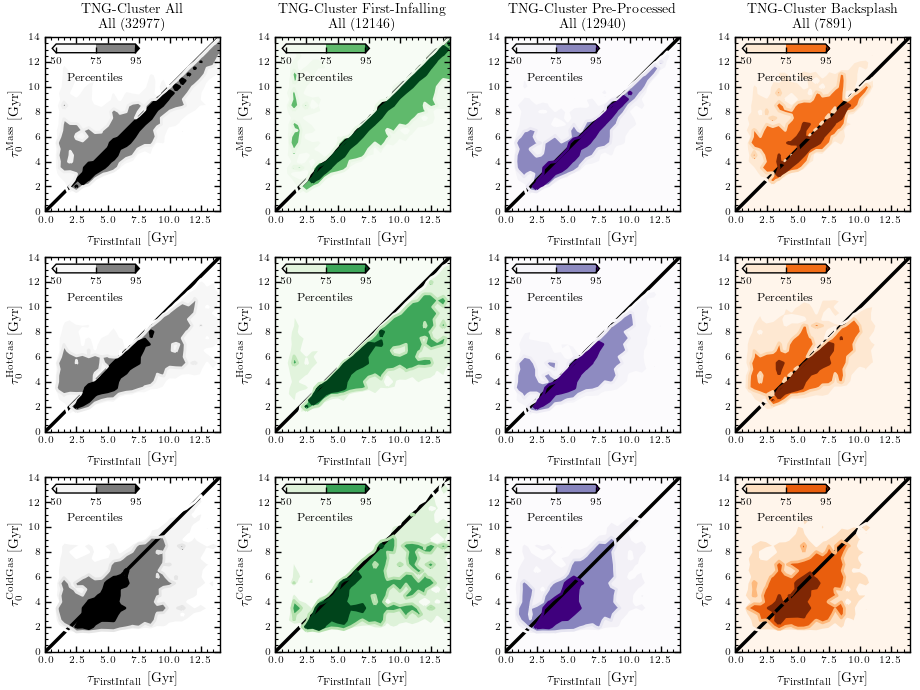

In [24]:
Sims = [TNGCluster_all, TNGCluster_clean, TNGCluster_PP, TNGCluster_BP]
fig, axs = plot_infalltimes_contours_comparison(Sims, savefig=savefig)

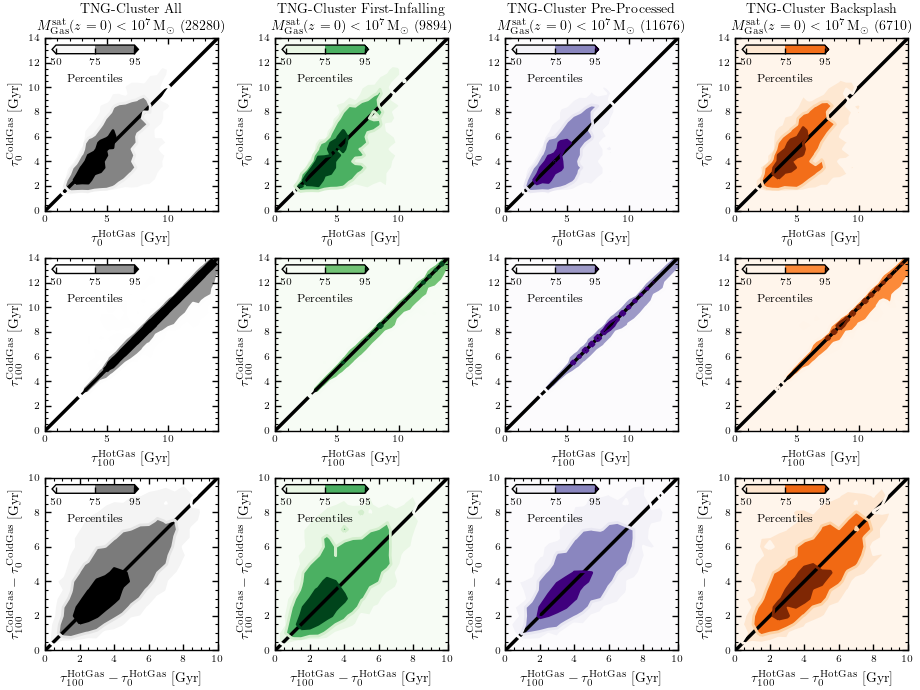

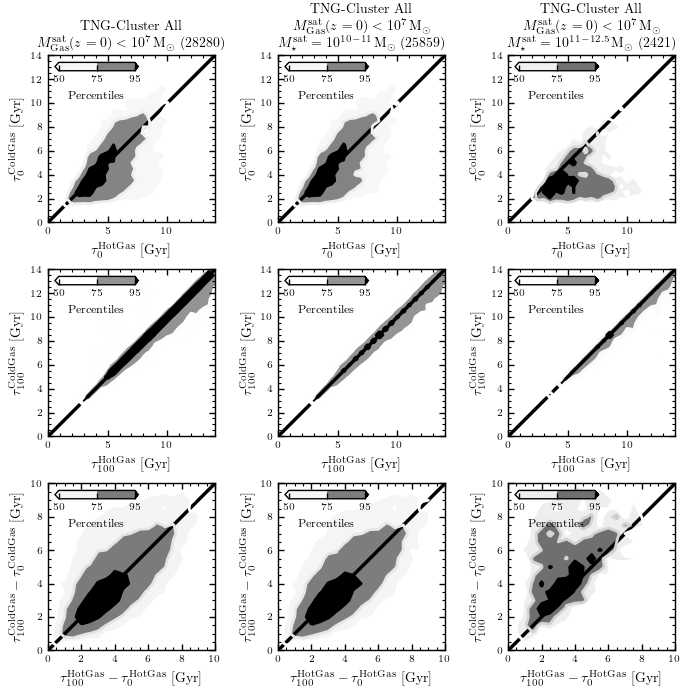

In [25]:

Sims = [TNGCluster_all_nogasz0, TNGCluster_clean_nogasz0, TNGCluster_PP_nogasz0, TNGCluster_BP_nogasz0]
fig, axs = plot_taugasloss_contours_comparison(Sims, savefig=savefig)

Sims = [TNGCluster_all_nogasz0, TNGCluster_all_nogas_lowmass, TNGCluster_all_nogas_highmass]
fig, axs = plot_taugasloss_contours_comparison(Sims, savefig=savefig)

In [26]:
def plot_time_distributions(Sims,
                            x_keys=[tau0_key, tau100_key, tstrip_key],
                            x_labels=[tau0_label, tau100_label, tstrip_label],
                            savefig=False, legend=True, add_mstar_m200c_info=False):
    """
    Plot 1d histogram distributions for the given x quantities
    Default is tau0, tau100, tauRPS for the standard definition.
    """
    
    if len(x_keys) != len(x_labels):
        print('Wrong number of x_keys or x_labels.')
        return
    
    fig, axs = plt.subplots(1, len(x_keys), sharey=True, figsize=(figsizewidth, figsizewidth/2.5))
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
        
    if 'Tstrip' in x_keys[0]:
        x_text = 0.95
        ha = 'right'
        save_key = 'tstrip'
    elif 'T' in x_keys[0]:
        x_text = 0.05
        ha = 'left'
        save_key = 'taus'
        
    axs, _ = plot_1Dhistograms(Sims, axs, x_keys, x_labels,
                               y_step=0.10, x_text=x_text, ha=ha, plot_mask=True)
        
    axs[0] = add_redshift_sincez2(axs[0])
    axs[1] = add_redshift_sincez2(axs[1])
    axs[2].set_xlim(-0.5, 10.1)
    
    ### add some extra info and text
    # axs[0]: clarify tau0 == infall time
    text = r'$\tau_0 \equiv$ infall time'
    textkwargs = dict(ha='left', va='top', transform=axs[0].transAxes, **text_kwargs)
    text = axs[0].text(0.05, 0.95, text, **textkwargs)
        
    # axs[1]: state the Mstar and M200c ranges for each sample
    if add_mstar_m200c_info:
        textkwargs = dict(ha='left', va='top', ma='left', transform=axs[1].transAxes, **text_kwargs)
        xval = 0.05
        yval = 0.95
        ystep = 0.11
        ymstar = yval - ystep
        ym200c = ymstar - ystep * 3
        for i, Sim in enumerate(Sims):
            if i == 0:
                axs[1].text(xval, yval, r'at $z=0:$', **textkwargs)
                axs[1].text(xval, ymstar, r'$\lg[M_{\star}^{\rm sat}] \in$', **textkwargs)
                axs[1].text(xval, ym200c, r'$\lg[M_{\rm 200c}^{\rm host}] \in$', **textkwargs)
            c = Sim.plotkwargs['color']
            mstarlolim = ru.floor_to_value(np.log10(Sim.tau_dict[Mstarz0_key].min()), 0.1)
            mstarhilim = ru.ceil_to_value(np.log10(Sim.tau_dict[Mstarz0_key].max()), 0.1)
            m200clolim = ru.floor_to_value(np.log10(Sim.tau_dict[M200cz0_key].min()), 0.1)
            m200chilim = ru.ceil_to_value(np.log10(Sim.tau_dict[M200cz0_key].max()), 0.1)
            axs[1].text(xval, ymstar - ystep*(i + 1), r'$(%.1f, %.1f)$'%(mstarlolim, mstarhilim), c=c, **textkwargs)
            axs[1].text(xval, ym200c - ystep*(i + 1), r'$(%.1f, %.1f)$'%(m200clolim, m200chilim), c=c, **textkwargs)
        
    if legend:
        legend_handels = add_histlegend_gasz0(Sims)
        fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(0.5, 1.15), loc='lower center', bbox_transform=axs[1].transAxes,
                   title=Sims[0].sim_label + ' ' + Sims[0].taudict_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_tau_distributions.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
            
    return fig, axs

def add_histlegend_gasz0(Sims):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for Sim in Sims:
        histkwargs = Sim.histkwargs
        tau_dict = Sim.tau_dict
        Nobjects = np.where(tau_dict[tau0_key] != -1)[0].size
        label = Sim.gasz0_label + ' (%d)'%Nobjects
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result


In [27]:
for key in tau_dict.keys():
    if 'strip' in key:
        print(key)

Tstrip_tau_infall_ColdGas_tau0-tau100
Tstrip_tau_infall_Gas_tau0-tau100
Tstrip_tau_infall_HotGas_tau0-tau100
Tstrip_tau_infall_Mass_tau0-tau100
Tstrip_tau_medpeak_ColdGas_tau0-tau100
Tstrip_tau_medpeak_Gas_tau0-tau100
Tstrip_tau_medpeak_HotGas_tau0-tau100
Tstrip_tau_medpeak_Mass_tau0-tau100


Text(0.5, 1.0, 'TNG-Cluster All \n $M_{\\rm Gas}^{\\rm sat}(z=0) < 10^{7}\\, {\\rm M_\\odot}$ (28280) ')

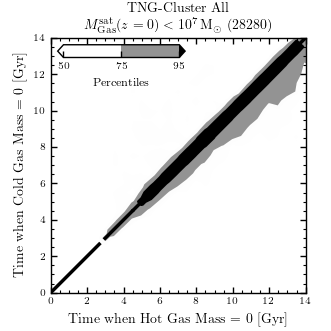

In [28]:
#Sim = TNGCluster_clean_lowmass_nogas
Sim = TNGCluster_all_nogasz0
fig, ax = plt.subplots(1, 1, figsize=(figsizewidth_column, figsizewidth_column))

x_label = r'Time when Hot Gas Mass = 0 [Gyr]'
x_key = 'CosmicTime_tau_medpeak_HotGas100'

# top axis: peak subhalo mass vs infall time
y_key = 'CosmicTime_tau_medpeak_ColdGas100'
y_label = r'Time when Cold Gas Mass = 0 [Gyr]'

ax = plot_2dhist_smoothed(Sim, ax, x_key, y_key,
                          loc='upper left')
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
ax.plot(ax.get_xlim(), ax.get_ylim(), **one_one_kwargs)
ax.set_box_aspect(1)
ax.set_title('%s '%(Sim.plot_label), fontsize='medium')


L680n8192TNG_all_nogasz0 28280 11
L680n8192TNG_all_nogasz0 28280 117
L680n8192TNG_all_nogasz0 28280 121
L680n8192TNG_all_nogasz0 28280 11
L680n8192TNG_all_nogasz0 28280 55
L680n8192TNG_all_nogasz0 28280 55


(-0.5, 10.1)

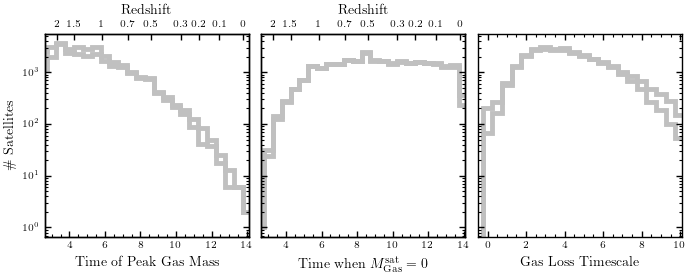

In [29]:
Sim = TNGCluster_all_nogasz0

x_keys = ['CosmicTime_tau_medpeak_HotGas0', 'CosmicTime_tau_medpeak_HotGas100', 'Tstrip_tau_medpeak_HotGas_tau0-tau100']
x_labels = ['Time of Peak Gas Mass', r'Time when $M_{\rm Gas}^{\rm sat}=0$', 'Gas Loss Timescale']
savefig = False
legend = True
add_mstar_m200c_info = False

fig, axs = plt.subplots(1, len(x_keys), sharey=True, figsize=(figsizewidth, figsizewidth/2.5))
axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)

if 'Tstrip' in x_keys[0]:
    x_text = 0.95
    ha = 'right'
    save_key = 'tstrip'
elif 'T' in x_keys[0]:
    x_text = 0.05
    ha = 'left'
    save_key = 'taus'
    
axs, _ = plot_1Dhistograms([Sim], axs, x_keys, x_labels,
                           y_step=0.10, x_text=x_text, ha=ha, plot_mask=True)

x_keys = ['CosmicTime_tau_medpeak_ColdGas0', 'CosmicTime_tau_medpeak_ColdGas100', 'Tstrip_tau_medpeak_ColdGas_tau0-tau100']
axs, _ = plot_1Dhistograms([Sim], axs, x_keys, x_labels,
                           y_step=0.10, x_text=x_text, ha=ha, plot_mask=True)
    
axs[0] = add_redshift_sincez2(axs[0])
axs[1] = add_redshift_sincez2(axs[1])
axs[2].set_xlim(-0.5, 10.1)

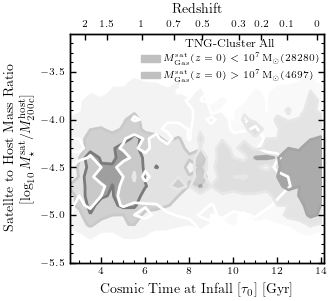

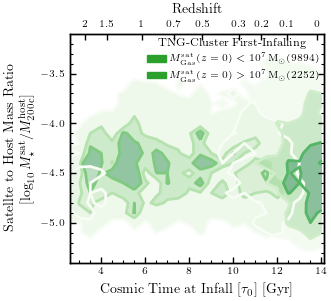

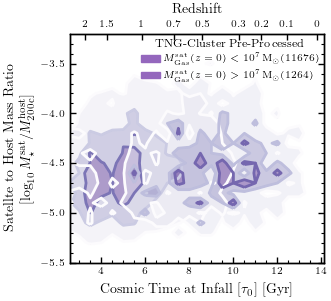

In [30]:
def plot_muz0_infalltimes_contours(Sims, savefig=False):
    """
    Plot muz0 vs infall time [tau_0] as contours for 
    each Sim in Sims. Sims should be a list of Sim classes.
    Optionally save the figure.
    Returns fig, ax
    """
    x_key = infall_key
    x_label = infall_label
    y_key = muz0_key
    y_label = 'Satellte to Host Mass Ratio \n' + r'[$\log_{10} M_{\star}^{\rm sat} / M_{\rm 200c}^{\rm host}$]'
    x_binwidth = 0.5
    y_binwidth = 0.1

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizewidth_column / 1.1))
    ax.set_ylabel(y_label, **axislabel_kwargs)
    ax.set_xlabel(x_label, **axislabel_kwargs)
    ax = add_redshift_sincez2(ax, label=True)
    
    percentiles = [50, 84, 95, 100]
    
    patches = []
        
    for Sim in Sims:
        tau_dict = Sim.tau_dict

        x = tau_dict[x_key]
        y = np.log10(tau_dict[y_key])
        
        mask = x > 0
        y = y[mask]
        x = x[mask]
        
        x_bins, x_bincents = ru.returnbins(x, x_binwidth)
        y_bins, y_bincents = ru.returnbins(y, y_binwidth)
        c = np.ones(x.size)
        bins = [x_bins, y_bins]
    
        statistic = scipy.stats.binned_statistic_2d(y, x, c, statistic='count', bins=[bins[1], bins[0]])
        extent = [bins[0][0], bins[0][-1], 
                  bins[1][0], bins[1][-1]]        
        
        vals = statistic[0]

        # plot contours based on percentiles
        levels = np.zeros(len(percentiles))
        for i, p in enumerate(percentiles):
            levels[i] = np.percentile(vals[vals > 0], p)
        
        patches.append(Patch(color=Sim.histkwargs['color'], label=Sim.gasz0_label + '(%d)'%(x.size)))
        ax.contour(x_bincents, y_bincents, vals, levels=levels, cmap=Sim.cmap, extend=extent, alpha=1.0)
        ax.contourf(x_bincents, y_bincents, vals, levels=levels, cmap=Sim.cmap, extend=extent, alpha=0.5)

    ax.legend(handles=patches, title='%s %s'%(Sim.sim_label, Sim.taudict_label),
              title_fontsize='small', fontsize='x-small')

    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_muz0_infalltime_contours.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, ax

def plot_muz0_infalltimes(Sims, savefig=False):
    """
    Plots muz0 vs infall time [tau_0] for each Sim in Sims
    Sims should be a list of Sim classes. 
    Optionally saves the figure.
    Returns fig, ax
    """

    x_key = infall_key
    x_label = infall_label
    y_key = muz0_key
    y_label = muz0_label_words

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizewidth_column / 1.1))
    ax.set_yscale('log')
    ax.set_ylabel(y_label, **axislabel_kwargs)
    ax.set_xlabel(x_label, **axislabel_kwargs)
    ax = add_redshift_sincez2(ax, label=True)
    
    percentiles = [16, 50, 84]

    for Sim in Sims:
        tau_dict = Sim.tau_dict

        x = tau_dict[x_key]
        y = tau_dict[y_key]

        mask = (x > 0) & (y > 0)

        x_plot = x[mask]
        y_plot = y[mask]

        ax.plot(x_plot, y_plot, label=(Sim.gasz0_label + ' (%d)'%x_plot.size), **Sim.plotkwargs)
        x_16 = np.percentile(x_plot, 16)
        x_84 = np.percentile(x_plot, 84)
        y_16 = np.percentile(y_plot, 16)
        y_84 = np.percentile(y_plot, 84)
        ax.fill_between([x_16, x_84], y_16, y_84, color=Sim.plotkwargs['color'], alpha=0.3)
        x_50 = np.median(x_plot)
        y_50 = np.median(y_plot)
        ax.axvline(x_50, color=Sim.plotkwargs['color'], **median_kwargs)
        print('x16, 50, 84: %.2g %.2g %.2g'%(x_16, x_50, x_84))
        print('y16, 50, 84: %.2e %.2e %.2e'%(y_16, y_50, y_84))
        """
        for percentile in percentiles:
            val = np.percentile(x_plot, percentile)
            if percentile == 50:
                kwargs = median_kwargs
            else:
                kwargs = vline_kwargs
            ax.axvline(val, color=Sim.plotkwargs['color'], **kwargs)
        """

    leg_kwargs = dict(ncol=1, bbox_to_anchor=(0.5, 1.25), loc='lower center', bbox_transform=ax.transAxes,
                      title='%s %s'%(Sim.sim_label, Sim.taudict_label), title_fontsize='medium', fontsize='small')

    ax.legend(**leg_kwargs)   
    
    # axs[1]: state the Mstar and M200c ranges for each sample
    textkwargs = dict(ha='left', va='top', ma='left', transform=ax.transAxes, fontsize='xx-small', **text_kwargs)
    xval = -0.2
    yval = 1.65
    ystep = 0.09
    ymstar = yval
    ym200c = ymstar - ystep * 3.1
    for i, Sim in enumerate(Sims):
        if i == 0:
            #ax.text(xval, yval, r'at $z=0:$', **textkwargs)
            ax.text(xval, ymstar, r'$\lg[M_{\star}^{\rm sat}] \in$', **textkwargs)
            ax.text(xval, ym200c, r'$\lg[M_{\rm 200c}^{\rm host}] \in$', **textkwargs)
        c = Sim.plotkwargs['color']
        mstarlolim = ru.floor_to_value(np.log10(Sim.tau_dict[Mstarz0_key].min()), 0.1)
        mstarhilim = ru.ceil_to_value(np.log10(Sim.tau_dict[Mstarz0_key].max()), 0.1)
        m200clolim = ru.floor_to_value(np.log10(Sim.tau_dict[M200cz0_key].min()), 0.1)
        m200chilim = ru.ceil_to_value(np.log10(Sim.tau_dict[M200cz0_key].max()), 0.1)
        ax.text(xval, ymstar - ystep*(i + 1), r'$(%.1f, %.1f)$'%(mstarlolim, mstarhilim), c=c, **textkwargs)
        ax.text(xval, ym200c - ystep*(i + 1), r'$(%.1f, %.1f)$'%(m200clolim, m200chilim), c=c, **textkwargs)
        
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_muz0_infalltime.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, ax

Sims = [TNGCluster_all_nogasz0,
        TNGCluster_all_gasz0]

#fig, ax = plot_muz0_infalltimes(Sims, savefig=savefig)
fig, ax = plot_muz0_infalltimes_contours(Sims, savefig=savefig)

Sims = [TNGCluster_clean_nogasz0,
        TNGCluster_clean_gasz0]

#fig, ax = plot_muz0_infalltimes(Sims, savefig=savefig)
fig, ax = plot_muz0_infalltimes_contours(Sims, savefig=savefig)

Sims = [TNGCluster_PP_nogasz0,
        TNGCluster_PP_gasz0]

#fig, ax = plot_muz0_infalltimes(Sims, savefig=savefig)
fig, ax = plot_muz0_infalltimes_contours(Sims, savefig=savefig)


In [31]:
MGasz0_key = 'SubhaloGasMass_z0'
tau_dict = TNGCluster_all.tau_dict
unique = np.unique(tau_dict['HostSubhaloGrNr'])
M200c_unique = np.zeros(unique.size)
Nsat_100 = M200c_unique.copy()
Nsat_105 = M200c_unique.copy()
Nsat_110 = M200c_unique.copy()
Nsats_Mstar = [Nsat_100,
               Nsat_105,
               Nsat_110]

vals_Mstar = [10.**(10.0),
              10.**(10.5),
              10.**(11.0)]

Nsat_070 = M200c_unique.copy()
Nsat_090 = M200c_unique.copy()
Nsat_100 = M200c_unique.copy()
Nsats_gas = [Nsat_070,
             Nsat_090,
             Nsat_100]
vals_gas = [10.**(7.0),
            10.**(9.0),
            10.**(10.0)]


for halo_i, haloID in enumerate(unique):
    sat_indices = tau_dict['HostSubhaloGrNr'] == haloID
    Mstar_sats = tau_dict[Mstarz0_key][sat_indices]
    Mgas_sats = tau_dict[MGasz0_key][sat_indices]
    M200c_unique[halo_i] = tau_dict[M200cz0_key][sat_indices][0]
    for val_i, val in enumerate(vals_Mstar):
        Nsats_Mstar[val_i][halo_i] = np.where(Mstar_sats > vals_Mstar[val_i])[0].size
        Nsats_gas[val_i][halo_i] = np.where(Mgas_sats > vals_gas[val_i])[0].size



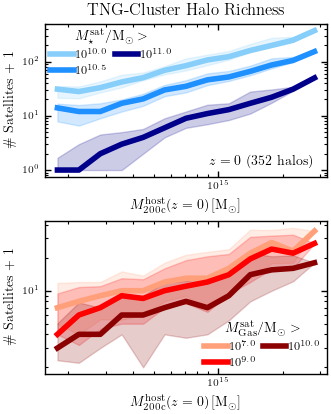

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(figsizewidth_column, figsizewidth_column*1.25))
colors_Mstar = ['lightskyblue', 'dodgerblue', 'darkblue']

colors_gas = ['lightsalmon', 'red', 'darkred']

Nsats_list = [Nsats_Mstar, Nsats_gas]
vals_list = [vals_Mstar, vals_gas]
colors_list = [colors_Mstar, colors_gas]

binwidth_log = 0.1

for ax_i, ax in enumerate(axs): 
    ax.set_xscale('log')
    ax.set_xlabel(M200cz0_label)
    ax.set_ylabel(r'\# Satellites + 1')
    ax.set_yscale('log')
    
    Nsats = Nsats_list[ax_i]
    vals = vals_list[ax_i]
    colors = colors_list[ax_i]
    for val_i, val in enumerate(vals):
        Nsat = Nsats[val_i]
        color = colors[val_i]
        bin_cents, y_50s, y_16s, y_84s = ru.return2dhiststats(np.log10(M200c_unique), Nsat, binwidth_log)
        
        #ax.plot(M200c_unique, Nsat, c=color, fillstyle='none')
        ax.plot(10.**(bin_cents), y_50s + 1, c=color, ls='-', lw=4, marker='None', label=r'$10^{%.1f}$'%np.log10(val))
        ax.fill_between(10.**(bin_cents), y_16s + 1, y_84s + 1, color=color, alpha=0.2)
        
    if ax_i == 0:
        ax.legend(title=r'$M_\star^{\rm sat} / {\rm M_\odot} > $', fontsize='small', ncol=2, loc='upper left')
        ax.set_title(r'TNG-Cluster Halo Richness')
        ax.text(0.95, 0.05, r'$z=0$ (352 halos)', ha='right', va='bottom', transform=ax.transAxes)
    else:
        ax.legend(title=r'$M_{\rm Gas}^{\rm sat} / {\rm M_\odot} > $', fontsize='small', ncol=2, loc='lower right')
    
if savefig:
    fname = 'L680n8192TNG_all_tot_HaloRichness.pdf'
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')
    

In [33]:
### investigate the evolution of the gas density radial profiles
# start by loading the GRP dictionary for a few z=0 gasless objects 
# start with low mass first-infalling objects
# trim tau_dict only to include satellites with MHgas > 1.0e10
Sim = TNGCluster_all_nogas_lowmass
tau_dict = Sim.tau_dict

subfindIDs = tau_dict['SubfindID']

# load input file into a dictionary
def load_grpdict():
    result = {}
    infname = 'subfind_L680n8192TNG_branches_all.hdf5'
    with h5py.File('../Output/L680n8192TNG_subfindGRP/' + infname, 'r') as f:
        for subfindID in subfindIDs:
            group_key = '%08d'%subfindID
            
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

grp_dict_clean_lowmass_nogas = load_grpdict()
grp_dict_clean_lowmass_nogas_keys = np.array(list(grp_dict_clean_lowmass_nogas.keys()))



In [34]:
def plot_SGRPevolution(grp_dict, grp_dict_key, savefig=False, clf=False):
    """
    Plot in two panels the evolution of hot and cold gas radial profiles.
    Start at the time of peak hot and cold gas mass and plot until there 
    is no more gas. Include some extra info in each panel about the 
    given subhalo.
    """
    
    group = grp_dict[grp_dict_key]
    
    fig, axs = plt.subplots(2, 1, figsize=(figsizewidth, figsizeheight*1.5))
    
    gastypes = ['HotGas', 'ColdGas']
    cmaps = ['Reds', 'Blues']
    for i, gastype in enumerate(gastypes):
        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(3.0e-1, 1.0e3)
        ax.set_ylim(1.0e-2, 1.0e8)
        ax.set_xlabel(r'Galacto-centric distance $[r / 2R_{\star}]$')
        ax.set_ylabel(r'$\rho_{\rm s1}^{\rm sub}(r + {\rm d}r)\, [{\rm M_\odot\, kpc^{-3}}]$'.replace('s1', gastype))
        
        start = np.where(group['tau_medpeak_%s'%gastype] == 0)[0][0]
        end = np.where(group['tau_medpeak_%s'%gastype] == 100)[0]
        if end.size == 0:
            return
        end = end.max()
        time_at_peak = group['CosmicTime'][start]
        
        xs = []
        ys = []
        cs = []
        
        # loop over the snapshots
        for index in range(start, end, -1):
            x = group['radii'][index]
            y = group['Subhalo%sDensityShells'%gastype][index]
            
            plot_indices = y > 0

            xs.append(x[plot_indices])
            ys.append(y[plot_indices])

            cs.append(group['CosmicTime'][index] - time_at_peak)  
        # end loop over snapshots
        kwargs = dict(path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()],
                      cmap=cmaps[i])
    
        lc = ru.multiline(xs, ys, cs, ax=ax, **kwargs)
        
        # add the colorbar 
        loc = 'lower left'
        cax = inset_axes(ax, width='50%', height='5%', loc=loc) 
        cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
        cbar.set_label(r'Time since max $M_{\rm s1}^{\rm sat}$ [Gyr]'.replace('s1', gastype), labelpad=5, fontsize='small')
        cbar.ax.tick_params(labelsize='x-small')
        cax.minorticks_off()
        if 'lower' in loc:
            cax.xaxis.set_label_position('top')
            cax.xaxis.set_ticks_position('top')
            
        # add some extra info about the galaxy
        ax.text(3.5e-1, 1.0e1, (r'Cosmic Time at max $M_{\rm s1}^{\rm sat}$ = %.1f [Gyr]'%time_at_peak).replace('s1', gastype),
                ha='left', va='bottom', fontsize='small')
        
        if i == 0:
            ax.set_title('TNG Cluster subfindID %s at snap 099'%grp_dict_key)
            ax.text(9.0e2, 3.0e7, r'$M_{\star}^{\rm sat}(z=0) = s1\, [{\rm M_\odot}]$'.replace('s1',ru.latex_float(group['Subhalo_Mstar_Rgal'][0], 1)),
                    va='top', ha='right', fontsize='small')
            ax.text(9.0e2, 3.0e6, r'$M_{\rm 200c}^{\rm host}(z=0) = s1\, [{\rm M_\odot}]$'.replace('s1',ru.latex_float(group['HostGroup_M_Crit200'][0], 1)),
                    va='top', ha='right', fontsize='small')            
        if i == 1:
            infall_index = np.where(group['tau_infall_%s'%gastype] == 0)[0][0]
            infall_time = group['CosmicTime'][infall_index]
            ax.text(9.0e2, 3.0e7, 'Infall Time: %.1f [Gyr]'%infall_time, va='top', ha='right', fontsize='small')
            peakmass_index = np.where(group['tau_medpeak_Mass'] == 0)[0][0]
            peakmass_time = group['CosmicTime'][peakmass_index]
            ax.text(9.0e2, 3.0e6, 'Time of max mass: %.1f [Gyr]'%peakmass_time, va='top', ha='right', fontsize='small')
            
            
    if savefig:
        fname = 'L680n8192TNG_snap099_subfindID%s_SGRPevolution.pdf'%grp_dict_key
        direc = '../Figures/TNGCluster/SGRPevolution/'
        fig.savefig(direc + fname, bbox_inches='tight')
        
    if clf:
        plt.close(fig)
        return
            
    # finish loop over gas types
    return fig, axs

/tmp/ipykernel_37926/4177279766.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 1, figsize=(figsizewidth, figsizeheight*1.5))


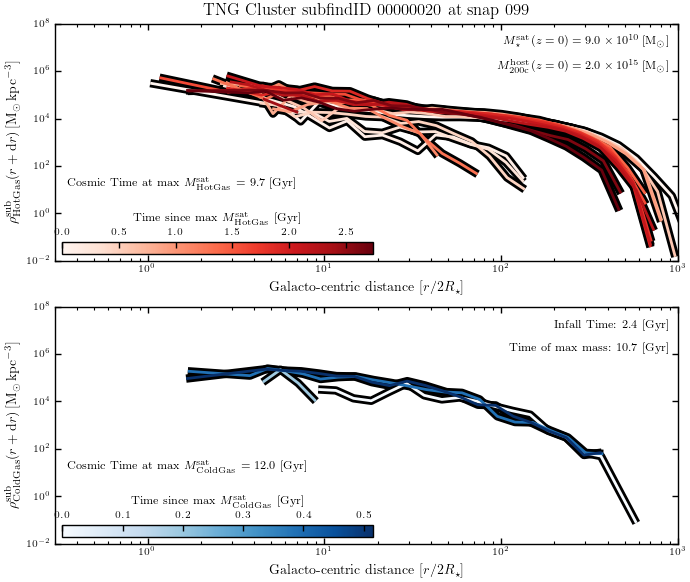

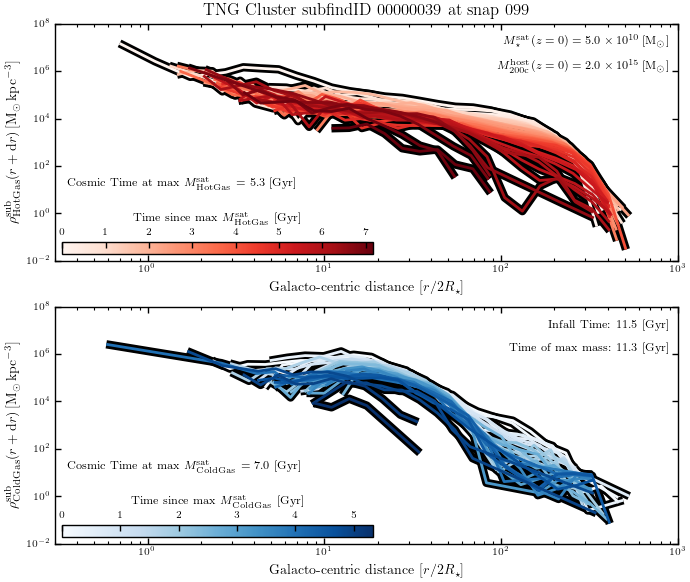

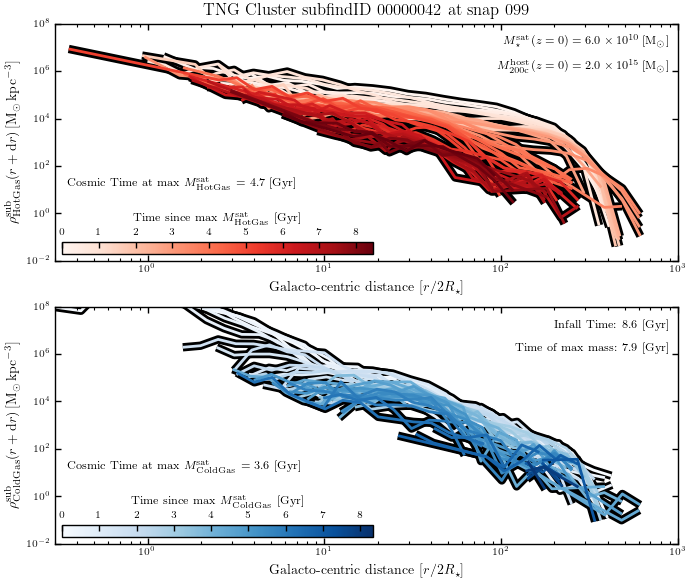

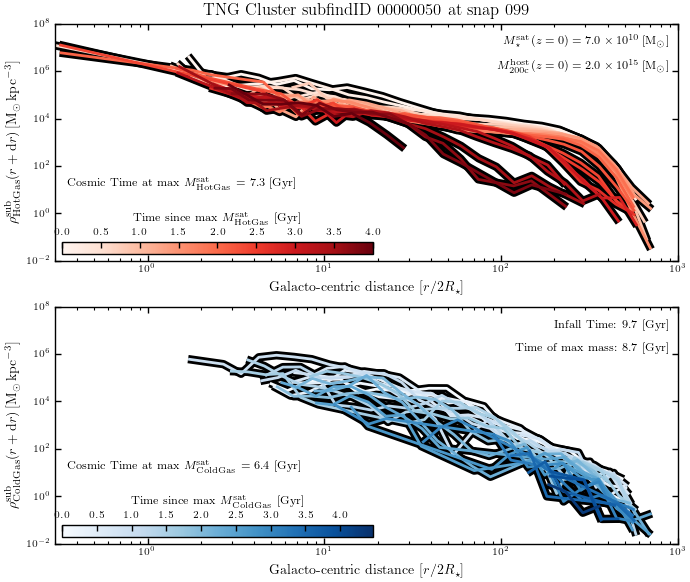

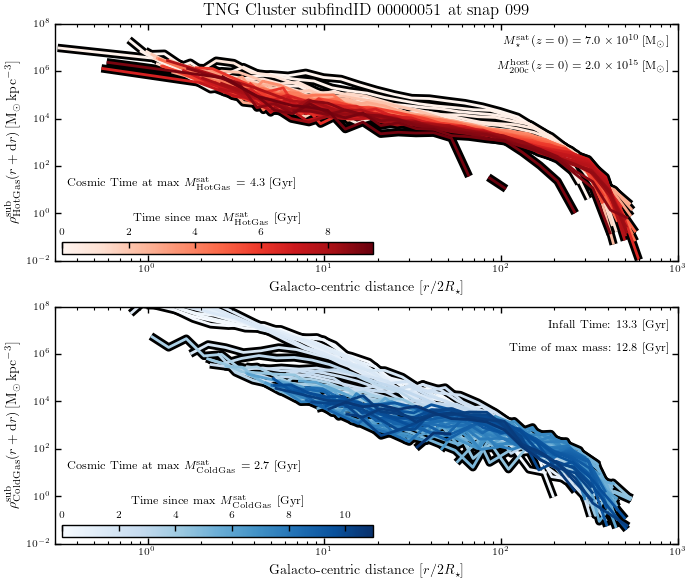

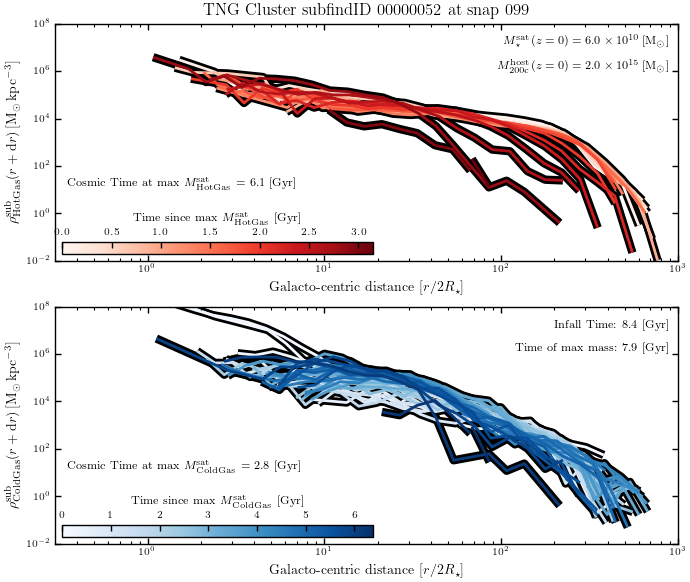

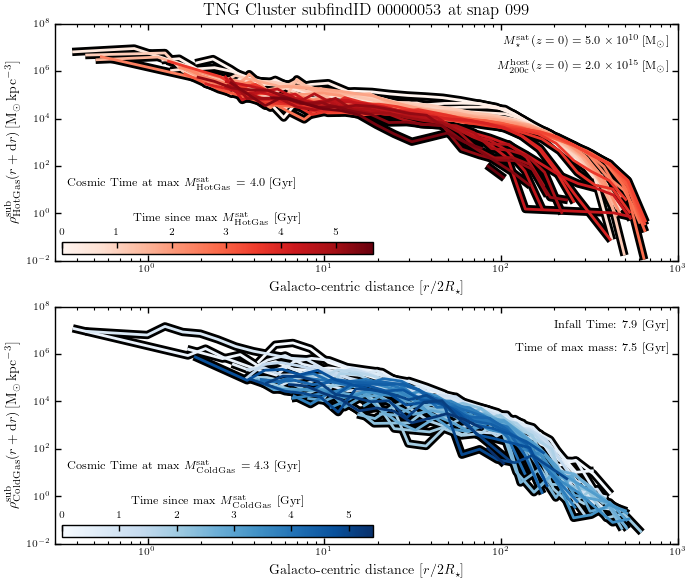

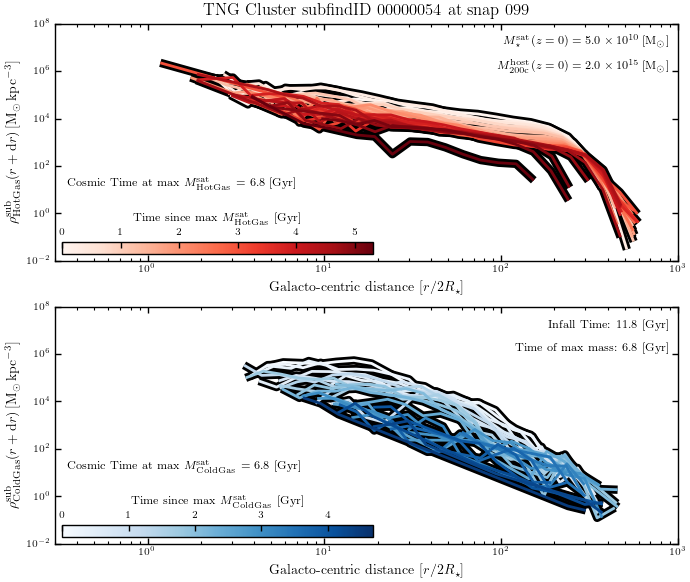

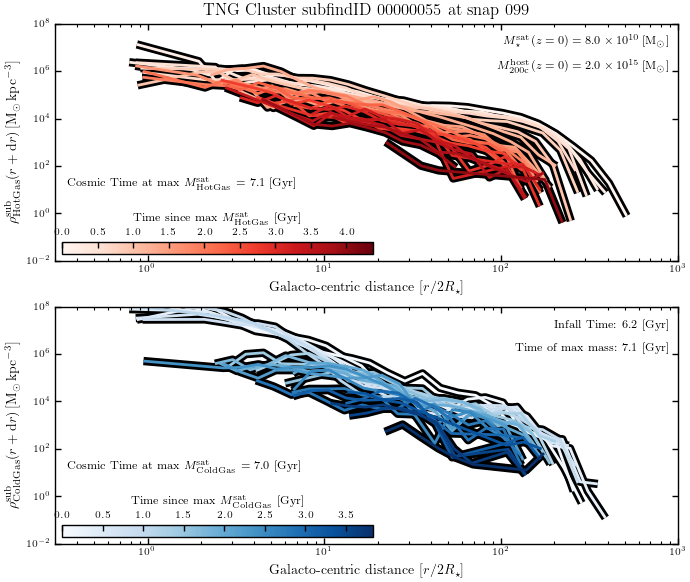

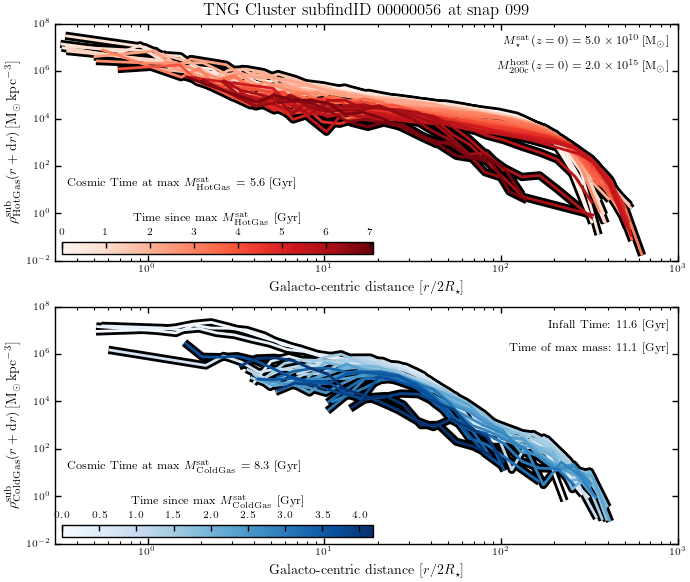

In [35]:
for grp_dict_key in grp_dict_clean_lowmass_nogas_keys[:10]:
    plot_SGRPevolution(grp_dict_clean_lowmass_nogas, grp_dict_key, savefig=False, clf=False)

In [62]:
def plot_colored2dhist(Sim, x_key=Mstarz0_key, y_key=MHGasz0_key,
                       x_label=r'$\log_{10}\left[M_{\star}^{\rm sat}(z=0) / {\rm M_\odot}\right]$',
                       y_label=r'$\log_{10}\left[M_{\rm HotGas}^{\rm sat}(z=0) / {\rm M_\odot}\right]$',
                       x_binwidth=0.25, y_binwidth=None,
                       c_key=M200cz0_key, c_log=True,
                       cmap='viridis', c_label=r'Median Host Mass [$M_{\rm 200c}^{\rm host} / {\rm M_\odot}$]',
                       add_contours=True, savefig=False):
    """
    For the given Sim, plot the 2D log-log x-y histogram colorcoded by the median c_key. 
    Optionally can overplot the contours denoting the population.
    """
    if c_log: 
        norm = mpl.colors.LogNorm()
    else:
        norm = None

    if y_binwidth is None:
        y_binwidth = x_binwidth
        
    binwidth = 0.3
    tau_dict = Sim.tau_dict
    indices = (tau_dict[x_key] > 0) & (tau_dict[y_key] > 0)
    x = np.log10(tau_dict[x_key][indices])
    y = np.log10(tau_dict[y_key][indices])
            
    x_bins, x_bincents = ru.returnbins(x, x_binwidth)
    y_bins, y_bincents = ru.returnbins(y, y_binwidth)
    c = tau_dict[c_key][indices]
    bins = [x_bins, y_bins]
    
    statistic = scipy.stats.binned_statistic_2d(y, x, c, statistic='median', bins=[bins[1], bins[0]])
    
    extent = [bins[0][0], bins[0][-1], 
              bins[1][0], bins[1][-1]]
    
    fig, ax = plt.subplots()

    h = ax.imshow(statistic[0], norm=norm, origin='lower', aspect='auto', cmap=cmap,
                  extent=extent)
        
    cbar = fig.colorbar(h, ax=ax, label=c_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(Sim.plot_label, fontsize='medium')
    
    if add_contours:
        statistic = scipy.stats.binned_statistic_2d(y, x, np.ones(x.size), statistic='count',
                                                    bins=[bins[1], bins[0]])

        vals = statistic[0]

        # plot contours based on percentiles
        percentiles = [16, 50, 84, 95]
        levels = np.zeros(len(percentiles))
        for i, p in enumerate(percentiles):
            levels[i] = np.percentile(vals[vals > 0], p)
        
        colors = ['lightgray', 'darkgray', 'gray', 'black']
        ax.contour(x_bincents, y_bincents, vals, levels=levels, colors=colors, extend=extent)

    if (savefig):
        fname = 'L680n8192TNG_all_gasz0_%s-%s-%s.pdf'%(x_key, y_key, c_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
            
            
    return fig, ax

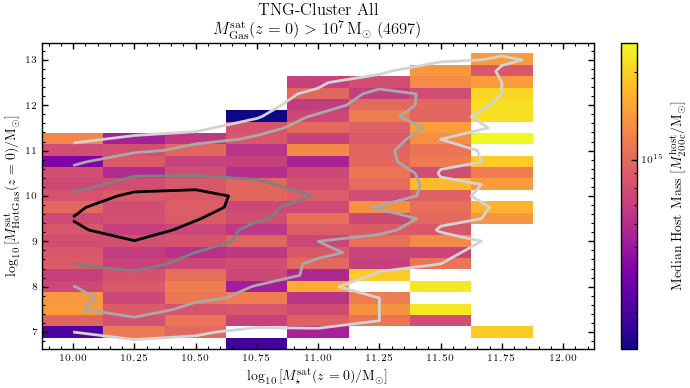

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/matplotlib/ticker.py:1108: UserWarning: Warning: converting a masked element to nan.
  return '%-12g' % value
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/matplotlib/ticker.py:1108: UserWarning: Warning: converting a masked element to nan.
  return '%-12g' % value


In [37]:
Sim = TNGCluster_all_gasz0
fig, ax =  plot_colored2dhist(Sim, cmap='plasma', savefig=savefig)

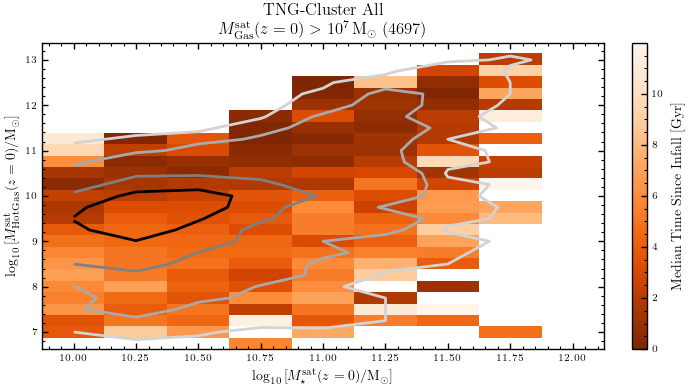

In [38]:
fig, ax = plot_colored2dhist(Sim, c_key=time_since_infall_key, c_log=False,
                             cmap='Oranges_r', c_label=r'Median Time Since Infall [Gyr]',
                             savefig=savefig)

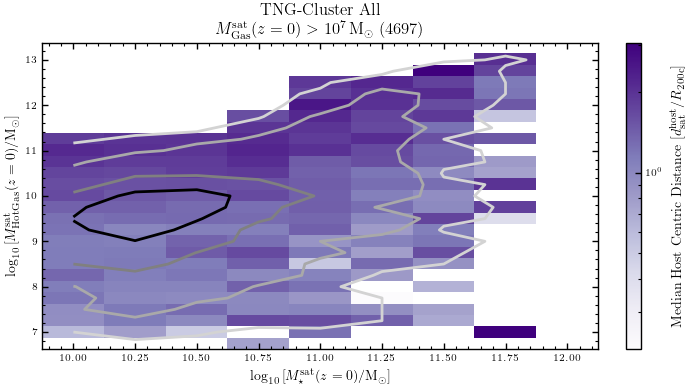

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/matplotlib/ticker.py:1108: UserWarning: Warning: converting a masked element to nan.
  return '%-12g' % value
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/matplotlib/ticker.py:1108: UserWarning: Warning: converting a masked element to nan.
  return '%-12g' % value


In [39]:
fig, ax = plot_colored2dhist(Sim, c_key=HCDnz0_key,
                             cmap='Purples', c_label=r'Median Host Centric Distance [$d_{\rm sat}^{\rm host}/ R_{\rm 200c}$]',
                             savefig=savefig)

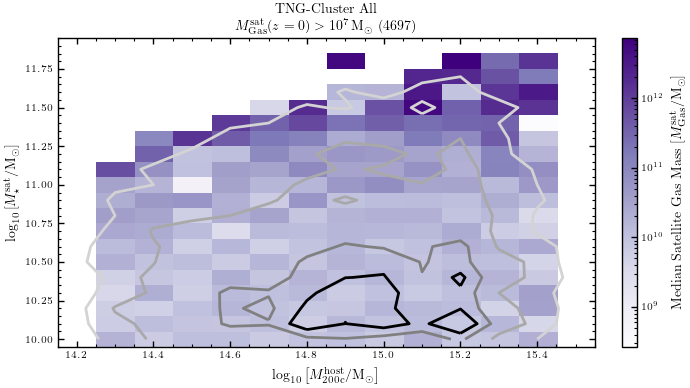

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/matplotlib/ticker.py:1108: UserWarning: Warning: converting a masked element to nan.
  return '%-12g' % value


In [63]:
Sim = TNGCluster_all_gasz0
x_key = M200cz0_key
x_label = r'$\log_{10}\left[M_{\rm 200c}^{\rm host} / {\rm M_\odot}\right]$'
y_key = Mstarz0_key
y_label = r'$\log_{10}\left[M_{\star}^{\rm sat} / {\rm M_\odot}\right]$'
x_binwidth = 0.1
y_binwidth = None
c_key = MGasz0_key
c_log = True
cmap = 'Purples'
c_label = r'Median Satellite Gas Mass [$M_{\rm Gas}^{\rm sat} / {\rm M_\odot}$]'
add_contours = True
savefig=False

fig, ax = plot_colored2dhist(Sim, x_key, y_key, x_label, y_label,
                             x_binwidth, y_binwidth, c_key, c_log,
                             cmap, c_label, add_contours, savefig)



        

In [40]:
# trim tau_dict only to include satellites with MHgas > 1.0e10
TNGCluster_all_largegasz0 = TNGSim(sim, all_key, gas_key)
tau_dict = TNGCluster_all_largegasz0.tau_dict

indices = tau_dict[MHGasz0_key] >= 1.0e10
for key in tau_dict.keys():
    tau_dict[key] = tau_dict[key][indices]
    
TNGCluster_all_largegasz0.plot_label = 'TNG-Cluster All \n' + r'$M_{\rm HotGas}^{\rm sat}(z=0) > 10^{10}\, {\rm M_\odot}$'
TNGCluster_all_largegasz0.save_label = 'L680n8192TNG_all_largegas'

add_time_since_infall_dset(TNGCluster_all_largegasz0)

subfindIDs = tau_dict['SubfindID']

# load input file into a dictionary
def load_grpdict():
    result = {}
    infname = 'subfind_L680n8192TNG_branches_all.hdf5'
    with h5py.File('../Output/L680n8192TNG_subfindGRP/' + infname, 'r') as f:
        for subfindID in subfindIDs:
            group_key = '%08d'%subfindID
            
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

grp_dict = load_grpdict()
grp_dict_keys = np.array(list(grp_dict.keys()))

In [41]:
rmin = 1
rmax = 1.0e3
binwidth_log = 0.1
_, radii_phys_bincents = ru.returnlogbins([rmin, rmax], binwidth_log)
radii_norm_bincents = grp_dict[grp_dict_keys[0]]['radii'][0,:] / grp_dict[grp_dict_keys[0]]['Subhalo_Rgal'][0]

def return_stacked_dict(tau_dict, dset_key, dset_bins):
    """
    Given the tau_dict, dset_key, and dset_dset_bins, bin all subhalos within
    the tau_dict by the dset_key and dset_dset_bins. Then within the stack,
    calculate the medians, 16th, and 84th percentiles of the densities both
    in normalized and physical radial coordinates. Note that this assumes linear
    interpolation between the nonzero density entries. 
    Resulting dictionary takes indices as keys, which lead to another dictionary 
    that takes '50_phys', '16_phys', '84_phys', '50_norm', '16_norm', '84_norm',
    and 'Ngal'. 'Ngal' is an integer, and all other entries are 1D arrays 
    corresponding to the global radii_phys_bincents and radii_norm_bincents 1D arrays.
    """
    
    result_dict = {}
    
    for bin_i in range(len(dset_bins)-1):
        result_dict[bin_i] = {}
        indices = ((tau_dict[dset_key] > dset_bins[bin_i]) &
                   (tau_dict[dset_key] < dset_bins[bin_i+1]))

        # initalize the outputs
        result_dict[bin_i]['50_phys'] = np.zeros((len(indices[indices]), len(radii_phys_bincents)), dtype=float) - 1.
        result_dict[bin_i]['16_phys'] = result_dict[bin_i]['50_phys'].copy()
        result_dict[bin_i]['84_phys'] = result_dict[bin_i]['50_phys'].copy()
        result_dict[bin_i]['50_norm'] = np.zeros((len(indices[indices]), len(radii_norm_bincents)), dtype=float) - 1.
        result_dict[bin_i]['16_norm'] = result_dict[bin_i]['50_norm'].copy()
        result_dict[bin_i]['84_norm'] = result_dict[bin_i]['50_norm'].copy()

        phys = np.zeros((len(indices[indices]), len(radii_phys_bincents)), dtype=float) - 1.
        norm = np.zeros((len(indices[indices]), len(radii_norm_bincents)), dtype=float) - 1.

        for index, subfindID in enumerate(tau_dict['SubfindID'][indices]):
            key = '%08d'%subfindID
            group = grp_dict[key]
            radii = group['radii'][0,:].copy()
            rgal = group['Subhalo_Rgal'][0].copy()
            densities = group['SubhaloHotGasDensityShells'][0,:].copy()
            nonz0_indices = densities > 0

            # interpolate the nonz0 densities and radii at the bincents
            phys[index,:] = np.interp(radii_phys_bincents, radii[nonz0_indices], densities[nonz0_indices])
            norm[index,:] = np.interp(radii_norm_bincents, radii[nonz0_indices]/rgal, densities[nonz0_indices])

        # finish loop of indices, save final results
        if np.min(phys) == -1:
            raise ValueError('not all indices of densities have been assigned.')

        result_dict[bin_i]['50_phys'] = np.median(phys, axis=0)
        result_dict[bin_i]['16_phys'] = np.percentile(phys, 16, axis=0)
        result_dict[bin_i]['84_phys'] = np.percentile(phys, 84, axis=0)

        result_dict[bin_i]['50_norm'] = np.median(norm, axis=0)
        result_dict[bin_i]['16_norm'] = np.percentile(norm, 16, axis=0)
        result_dict[bin_i]['84_norm'] = np.percentile(norm, 84, axis=0)

        result_dict[bin_i]['Ngal'] = len(norm)
        
    # finish loop over bins. return to main
    return result_dict


def plot_stacked_dict(Sim, stacked_dict, dset_key, dset_bins, dset_label, colors, radii='norm', savefig=False):
    """
    Plot the stacked_dict given the dict, dset_bins, and label.
    If radii=='norm', then use the normalized radial coordinates.
    If radii=='phys', use physical radial coordinates.
    """
    if radii == 'norm':
        x_label = r'Distance [$ r / 2R_{\rm half}^\star$]'
        radii_bincents = radii_norm_bincents
    elif radii == 'phys':
        x_label = r'Distance [$r / {\rm kpc}$]'
        radii_bincents = radii_phys_bincents
    else:
        raise ValueError('invalid radii value %s. Accepted values are norm and phys'%radii)
        
    if len(colors) < len(stacked_dict.keys()):
        raise ValueError('too few colors given')
    
    fig, ax = plt.subplots()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(x_label)
    ax.set_ylabel(r'Hot Gas Densitity [$\rho_{\rm Gas}^{\rm sat}({\rm shells}) / {\rm M_\odot\, kpc^{-3}}$]' )

    for i, bin_key in enumerate(stacked_dict.keys()):
        color = colors[i]
        densities_50 = stacked_dict[bin_key]['50_%s'%radii]
        densities_16 = stacked_dict[bin_key]['16_%s'%radii]
        densities_84 = stacked_dict[bin_key]['84_%s'%radii]
        Ngal = stacked_dict[bin_key]['Ngal']
        ax.plot(radii_bincents, densities_50, '-', color=color, label=r'$[%.2g, %.2g)\ (%d)$'%(dset_bins[i], dset_bins[i+1], Ngal))
        ax.fill_between(radii_bincents, densities_16, densities_84, color=color, alpha=0.2)

    ax.legend(title=dset_label)
    ax.set_title(Sim.plot_label)
    
    if (savefig):
        fname = '%s_MGasRadProf_Stack-%s_%s.pdf'%(Sim.save_label, dset_key, radii)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


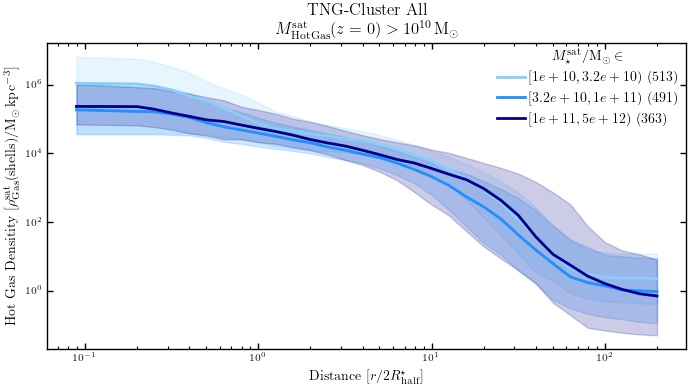

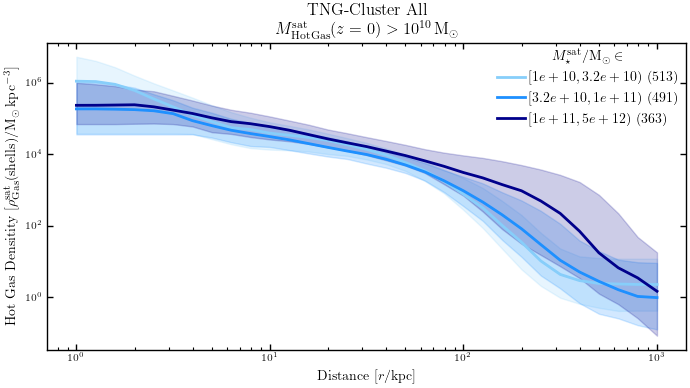

In [42]:
dset_key = Mstarz0_key
dset_bins = [10.**(10.0), 10.**(10.5), 10.**(11.0), 10.**(12.7)]
dset_label = r'$M_\star^{\rm sat} / {\rm M_\odot} \in$'
colors = ['lightskyblue', 'dodgerblue', 'darkblue']

stacked_dict = return_stacked_dict(tau_dict, dset_key, dset_bins)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='norm', savefig=savefig)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='phys', savefig=savefig)

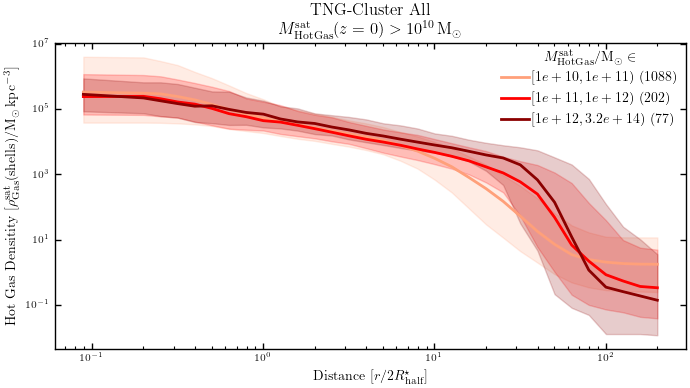

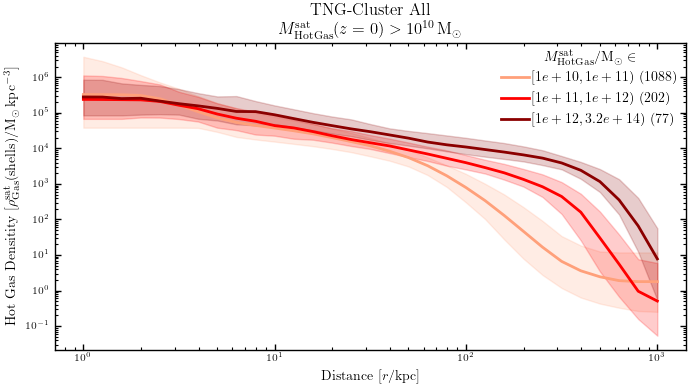

In [43]:
dset_key = MHGasz0_key
dset_bins = [10.**(10.0), 10.**(11.0), 10.**(12.0), 10.**(14.5)]
dset_label = r'$M_{\rm HotGas}^{\rm sat} / {\rm M_\odot} \in$'
colors = ['lightsalmon', 'red', 'darkred']

stacked_dict = return_stacked_dict(tau_dict, dset_key, dset_bins)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='norm', savefig=savefig)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='phys', savefig=savefig)

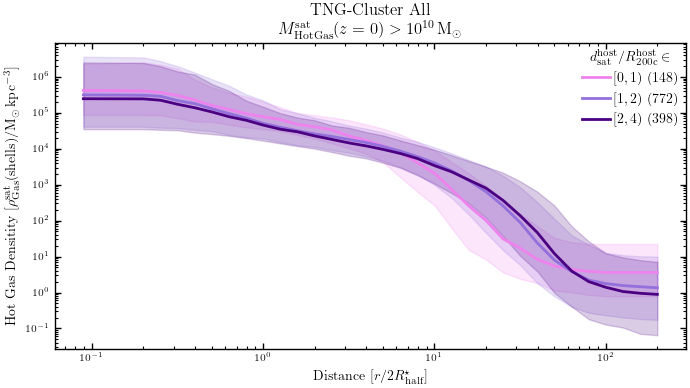

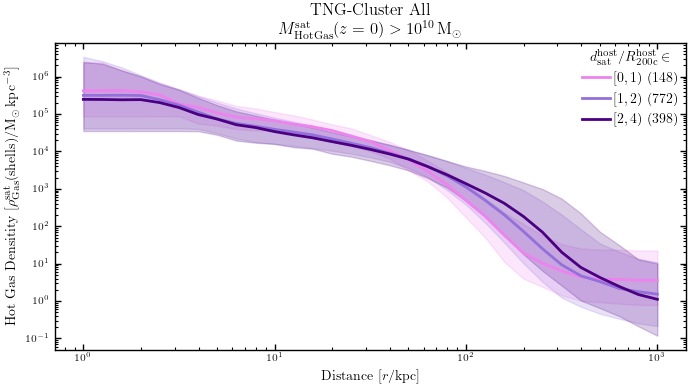

In [44]:
dset_key = HCDnz0_key
dset_bins = [0.0, 1.0, 2.0, 4.0]
dset_label = r'$d_{\rm sat}^{\rm host} / R_{\rm 200c}^{\rm host} \in$'
colors = ['violet', 'mediumpurple', 'indigo']

stacked_dict = return_stacked_dict(tau_dict, dset_key, dset_bins)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='norm', savefig=savefig)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='phys', savefig=savefig)

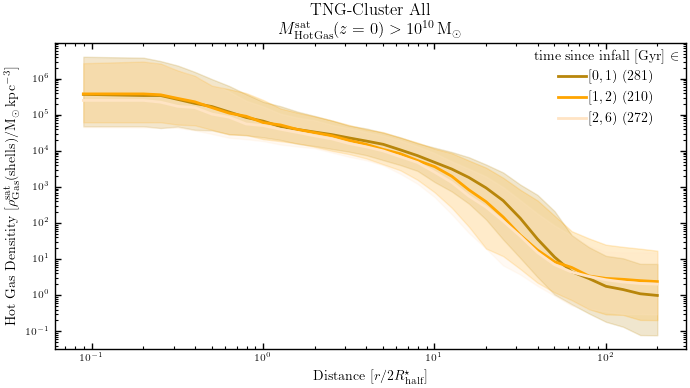

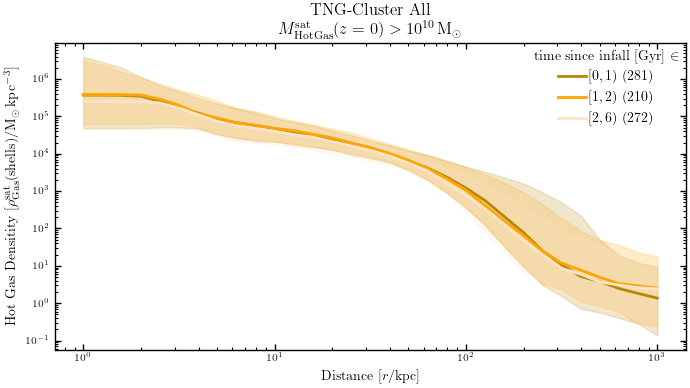

In [45]:
dset_key = time_since_infall_key
dset_bins = [0.0, 1.0, 2.0, 6.0]
dset_label = r'time since infall [Gyr] $\in$'
colors = ['darkgoldenrod', 'orange', 'bisque']

stacked_dict = return_stacked_dict(tau_dict, dset_key, dset_bins)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='norm', savefig=savefig)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='phys', savefig=savefig)

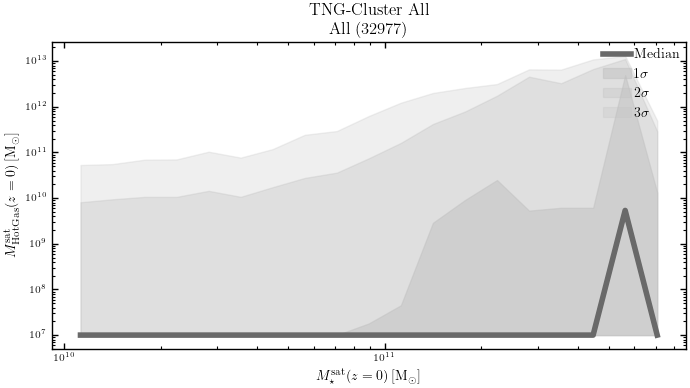

In [46]:
Sim = TNGCluster_all

tau_dict = Sim.tau_dict
Mstar = tau_dict[Mstarz0_key].copy()
MHGas = tau_dict[MHGasz0_key].copy()

MHGas_lolim = 1.0e7
MHGas[MHGas < MHGas_lolim] = MHGas_lolim

indices = Mstar > 0

mass_binwidth = 0.1

percentiles = [0.15, 2.5, 16, 50, 84, 97.5, 99.85]
sigmas = [3, 2, 1]
stats = ru.return2dhiststats_dict(np.log10(Mstar[indices]), np.log10(MHGas[indices]), mass_binwidth, percentiles)
bin_cents = 10**(stats['bin_cents'])

fig, ax = plt.subplots()

for i, sigma in enumerate(sigmas):
    lo_percentile = percentiles[i]
    hi_percentile = percentiles[-(i+1)]
    
    y_los = 10.**(stats[lo_percentile])
    y_his = 10.**(stats[hi_percentile])
    
    ax.fill_between(bin_cents, y_los, y_his, color=Sim.plotkwargs['color'], alpha=1./(sigma+1.), label='%d'%sigma + r'$\sigma$')

y_50s = 10.**(stats[50])
ax.plot(bin_cents, y_50s, c='dimgray', ls='-', lw=4, marker='None', label='Median')
  

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(Sim.plot_label)
ax.set_xlabel(Mstarz0_label)
ax.set_ylabel(MHGasz0_label)
h_orig, l_orig = ax.get_legend_handles_labels()
h_new = [h_orig[0]]
l_new = [l_orig[0]]
for index in range(1, len(h_orig)):
    h_new.append(h_orig[-index])
    l_new.append(l_orig[-index])
    print()
ax.legend(h_new, l_new)
if savefig:
    fname = '%s_%s-%s.pdf'%(Sim.save_label, MHGasz0_key, Mstarz0_key)
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')

In [47]:
Sim = TNGCluster_all
mass_binwidth = 0.15

tau_dict = Sim.tau_dict
Mstar = tau_dict[Mstarz0_key].copy()
MHGas = tau_dict[MHGasz0_key].copy()
MGas = tau_dict[MGasz0_key].copy()
MCGas = tau_dict[MCGasz0_key].copy()

Mstar_bins, Mstar_bincents = ru.returnlogbins(Mstar, mass_binwidth)

sort_indices = np.digitize(Mstar, Mstar_bins)
gaslessMgas_frac = np.zeros(Mstar_bincents.size, Mstar_bincents.dtype) - 1
NgaslessMgas = gaslessMgas_frac.copy()
gaslessMgas90_frac = gaslessMgas_frac.copy()
gaslessMgas100_frac = gaslessMgas_frac.copy()
gaslessMHGas_frac = gaslessMgas_frac.copy()
NgaslessMHgas = gaslessMgas_frac.copy()
gaslessMCGas_frac = gaslessMgas_frac.copy()
NgaslessMCgas = gaslessMgas_frac.copy()

for i, bincent in enumerate(Mstar_bincents):
    subset_indices = sort_indices == (i+1)
    Mgas_subset = MGas[subset_indices]
    if Mgas_subset.size == 0:
        continue
    gaslessMgas_frac[i] = Mgas_subset[Mgas_subset != 0].size / Mgas_subset.size 
    NgaslessMgas[i] = Mgas_subset[Mgas_subset != 0].size 
    gaslessMgas90_frac[i] = Mgas_subset[Mgas_subset >= 1.0e9].size / Mgas_subset.size
    gaslessMgas100_frac[i] = Mgas_subset[Mgas_subset >= 1.0e10].size / Mgas_subset.size
    Mhgas_susbset = MHGas[subset_indices]
    gaslessMHGas_frac[i] = Mhgas_susbset[Mhgas_susbset != 0].size / Mhgas_susbset.size
    NgaslessMHgas[i] = Mhgas_susbset[Mhgas_susbset != 0].size 
    Mcgas_subset = MCGas[subset_indices]
    gaslessMCGas_frac[i] = Mcgas_subset[Mcgas_subset != 0].size / Mcgas_subset.size
    NgaslessMCgas[i] = Mcgas_subset[Mcgas_subset != 0].size 



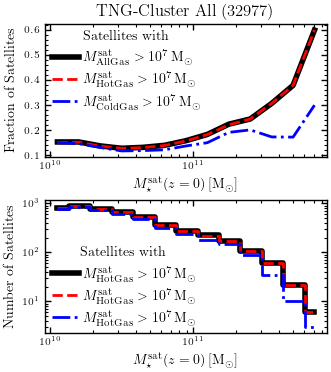

In [48]:
indices = gaslessMgas_frac != -1
fig, axs = plt.subplots(2, 1, figsize=(figsizewidth_column, figsizeheight_column * 2))

# top axis: fraction of satellites
ax = axs[0]
ax.plot(Mstar_bincents[indices], gaslessMgas_frac[indices], 'k-', lw=4, label=r'$M_{\rm AllGas}^{\rm sat} > 10^{7}\, {\rm M_\odot}$')
ax.plot(Mstar_bincents[indices], gaslessMHGas_frac[indices], 'r--', label=r'$M_{\rm HotGas}^{\rm sat} > 10^{7}\, {\rm M_\odot}$')
ax.plot(Mstar_bincents[indices], gaslessMCGas_frac[indices], 'b-.', label=r'$M_{\rm ColdGas}^{\rm sat} > 10^{7}\, {\rm M_\odot}$')
ax.set_xscale('log')
ax.set_title('TNG-Cluster All (%d)'%Mstar.size)
ax.set_xlabel(Mstarz0_label)
ax.set_ylabel('Fraction of Satellites')
ax.legend(loc='upper left', title='Satellites with')

# bottom axis: number of satellites
ax = axs[1]
ax.step(Mstar_bincents[indices], NgaslessMgas[indices], 'k-', where='mid', lw=4, label=r'$M_{\rm HotGas}^{\rm sat} > 10^{7}\, {\rm M_\odot}$')
ax.step(Mstar_bincents[indices], NgaslessMHgas[indices], 'r--', where='mid', label=r'$M_{\rm HotGas}^{\rm sat} > 10^{7}\, {\rm M_\odot}$')
ax.step(Mstar_bincents[indices], NgaslessMCgas[indices], 'b-.', where='mid', label=r'$M_{\rm HotGas}^{\rm sat} > 10^{7}\, {\rm M_\odot}$')
ax.set_yscale('log')
ax.set_ylabel(r'Number of Satellites')
ax.set_xlabel(Mstarz0_label)
ax.set_xscale('log')
ax.legend(loc='lower left', title='Satellites with')
if savefig:
    fname = '%s_fgassat-mstarz0.pdf'%(Sim.save_label)
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')

In [49]:
savefig=False